# Подключение библиотеки

In [1]:
import timeit
import time
import sys
import os
import re
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import display, HTML
from datetime import datetime

import matplotlib.pyplot as plt

from scipy import stats as st
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Многозадачная регрессия
from sklearn.multioutput import MultiOutputRegressor
# Для машинного обучения
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
# Метод ближайшего соседа KNN
from sklearn.neighbors import KNeighborsRegressor
# Метод опорного вектора, SVR - для регрессии
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

# Нейросети
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
# Для сборщика мусора
import gc

# Импорт и анализ данных

In [2]:
df = pd.read_csv('Amp_C_train.txt')

##### Рассмотрим содержимое датасет

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


In [4]:
# Приведение к нижнему регистру названия колонки
df.columns = df.columns.str.lower()

In [5]:
df.head()

time input                       output
0  0.000000e+00    0j    (1.0785e-42-9.30535e-43j)
1  5.000000e-09    0j   (4.00167e-44+4.80805e-45j)
2  1.000000e-08    0j   (5.73102e-46+1.23143e-45j)
3  1.500000e-08    0j  (-2.47356e-47+3.89672e-47j)
4  2.000000e-08    0j  (-1.56497e-48+2.91821e-51j)

# Предобработка данных

## Сделаем датасет в временной ряд

In [6]:
# Установка колонки 'time' в качестве индекса
df.set_index('time', inplace=True)

## Преобразование комплексных входных и выходных сигналов из строкового представления

In [7]:
df['input'] = df['input'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))
df['output'] = df['output'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))

## Изменим DataFrame с реальной и мнимой частями комплексных чисел

In [8]:
df['input_real'] = df['input'].apply(np.real)
df['input_imag'] = df['input'].apply(np.imag)
df['output_real'] = df['output'].apply(np.real)
df['output_imag'] = df['output'].apply(np.imag)

In [9]:
df.head()

input                                          output  \
time                                                                     
0.000000e+00  0.0+0.0j  1.078500e-42-9.305350e-                    43j   
5.000000e-09  0.0+0.0j  4.001670e-44+4.808050e-                    45j   
1.000000e-08  0.0+0.0j  5.731020e-46+1.231430e-                    45j   
1.500000e-08  0.0+0.0j -2.473560e-47+3.896720e-                    47j   
2.000000e-08  0.0+0.0j -1.564970e-48+2.918210e-                    51j   

              input_real  input_imag   output_real   output_imag  
time                                                              
0.000000e+00         0.0         0.0  1.078500e-42 -9.305350e-43  
5.000000e-09         0.0         0.0  4.001670e-44  4.808050e-45  
1.000000e-08         0.0         0.0  5.731020e-46  1.231430e-45  
1.500000e-08         0.0         0.0 -2.473560e-47  3.896720e-47  
2.000000e-08         0.0         0.0 -1.564970e-48  2.918210e-51

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype     
---  ------       --------------   -----     
 0   input        172032 non-null  complex128
 1   output       172032 non-null  complex128
 2   input_real   172032 non-null  float64   
 3   input_imag   172032 non-null  float64   
 4   output_real  172032 non-null  float64   
 5   output_imag  172032 non-null  float64   
dtypes: complex128(2), float64(4)
memory usage: 11.8 MB


In [11]:
df = df.drop(['input', 'output'], axis=1)

In [12]:
df.describe()

input_real     input_imag    output_real    output_imag
count  172032.000000  172032.000000  172032.000000  172032.000000
mean        0.000053      -0.000013      -0.001947      -0.000626
std         0.592007       0.593872       2.087976       2.087590
min        -2.229120      -2.202991      -3.449150      -3.441910
25%        -0.399091      -0.399775      -1.934853      -1.937512
50%        -0.000685      -0.000342      -0.010191       0.004920
75%         0.398777       0.401744       1.935345       1.929125
max         2.212461       2.192265       3.451210       3.460060

## График

In [13]:
def draw_plot_signal(signal_type, time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index

    # Построение объединенного графика
    plt.figure(figsize=(10, 6))
    
    # Входной сигнал
    plt.plot(time, filtered_data[f'{signal_type}_real'], label=f'{signal_type} Real Part', color='blue', linestyle='-')
    plt.plot(time, filtered_data[f'{signal_type}_imag'], label=f'{signal_type} Imaginary Part', color='red', linestyle='-')
    
    plt.title('Input and Output Signals')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def draw_all_plot_signal(time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index
    
    plt.figure(figsize=(15, 10))

    # График реальной части входного сигнала
    plt.subplot(2, 2, 1)
    plt.plot(time, filtered_data['input_real'], label='Real Part')
    plt.title('Real Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части входного сигнала
    plt.subplot(2, 2, 2)
    plt.plot(time, filtered_data['input_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График реальной части выходного сигнала
    plt.subplot(2, 2, 3)
    plt.plot(time, filtered_data['output_real'], label='Real Part')
    plt.title('Real Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части выходного сигнала
    plt.subplot(2, 2, 4)
    plt.plot(time, filtered_data['output_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

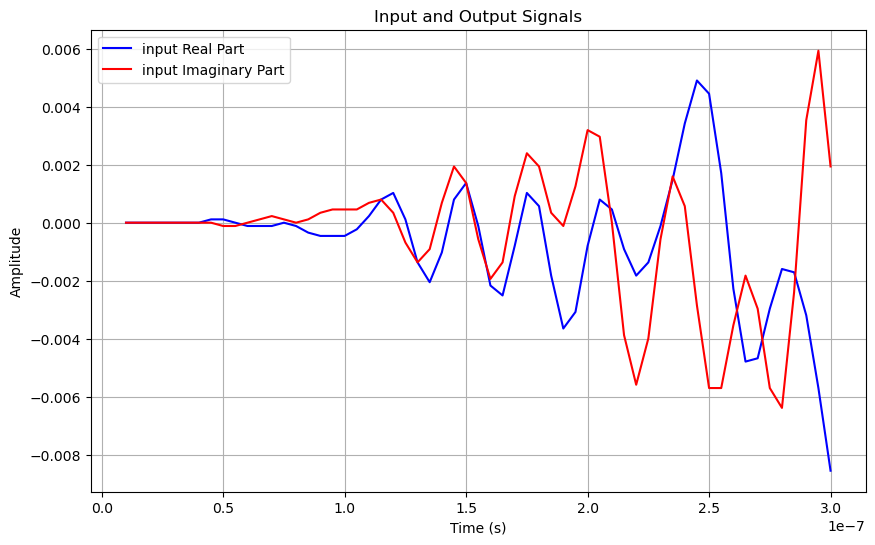

In [15]:
draw_plot_signal('input', time_start=1e-8, time_end=0.3e-6)

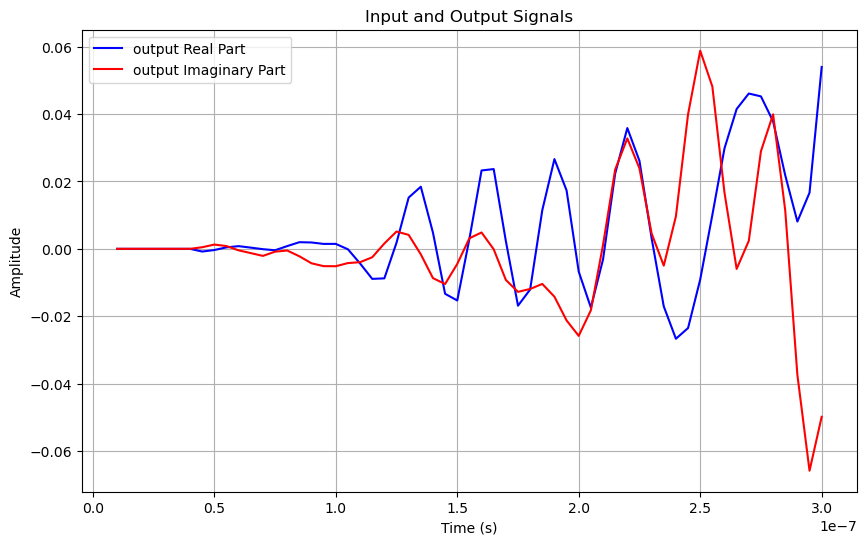

In [16]:
draw_plot_signal('output', time_start=1e-8, time_end=0.3e-6)

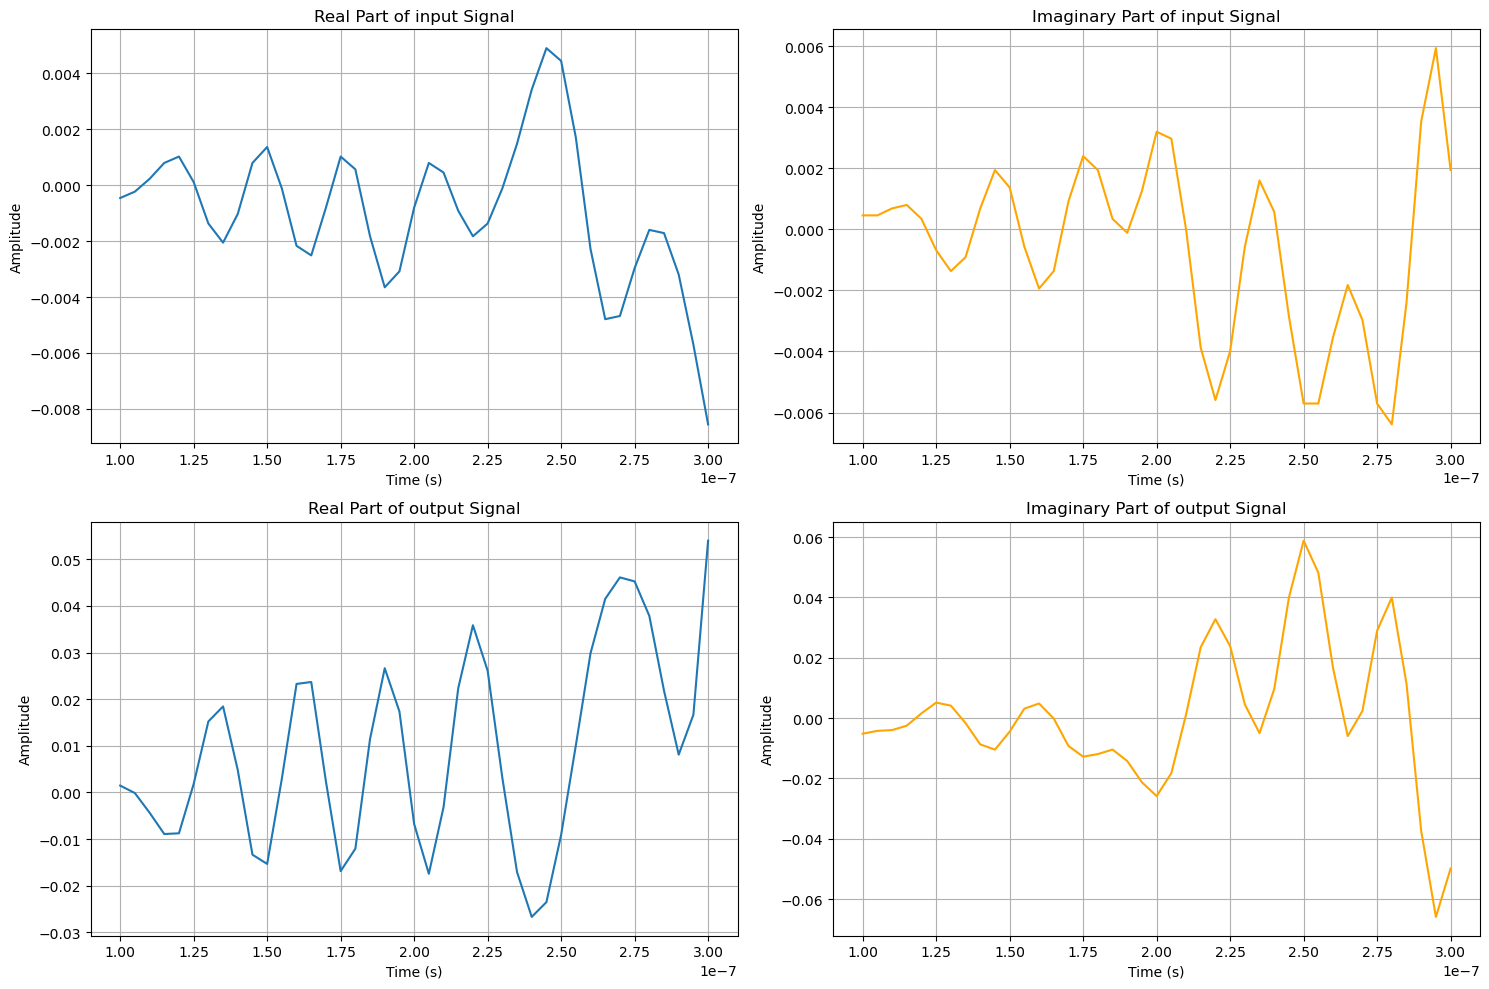

In [17]:
draw_all_plot_signal(time_start=1e-7, time_end=0.3e-6)

# Нейронное обучение

In [18]:
# Здесь будем сохранить результаты обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

Сложные динамические NN-модели можно разделить на три основных архитектурных класса следующим образом:

1. Complex Time Delay Recurrent Neural Network (CTRNN).
2. Complex Time Delay Neural Network (CTDNN).
3. Real Valued Time delay Recurrent Neural Network (RVTDRNN).
4. Real Valued Time Delay Neural Network (RVTDNN), also named as the Real
Valued Focused Time Delay Neural Network (RVFTDNN).

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   input_real   172032 non-null  float64
 1   input_imag   172032 non-null  float64
 2   output_real  172032 non-null  float64
 3   output_imag  172032 non-null  float64
dtypes: float64(4)
memory usage: 6.6 MB


In [20]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


## Сложные динамические NN-модели на PyTorch

### Complex Time Delay Recurrent Neural Network (CTDRNN)

#### Инициализация класса модели

In [21]:
class CTDRNN:
    def __init__(self, input_size, hidden_sizes, output_size, num_layers, num_epochs=100, learning_rate=0.001, p=10, q=5, batch_size=64):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.p = p
        self.q = q
        self.batch_size = batch_size

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = CTDRNN_Model(input_size, hidden_sizes, output_size, num_layers).to(self.device)
        self.criterion = nn.MSELoss().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        self.scaler_X = StandardScaler()
        self.scaler_Y = StandardScaler()

        self.loss_values = []

    def create_time_delays_with_feedback(self, X_real, X_imag, Y_real, Y_imag):
        X_delayed = []
        Y_delayed = []
        
        for i in range(max(self.p, self.q), len(X_real)):
            # Входные задержки для X_real и X_imag
            X_real_window = X_real.iloc[i-self.p:i+1].values  # Входные задержки (x(k), x(k-1), ..., x(k-p))
            X_imag_window = X_imag.iloc[i-self.p:i+1].values
            
            # Обратная связь для Y_real и Y_imag
            Y_real_window = Y_real.iloc[i-self.q:i].values  # Обратная связь (y(k-1), y(k-2), ..., y(k-q))
            Y_imag_window = Y_imag.iloc[i-self.q:i].values
            
            # Комбинируем вещественные и мнимые части
            X_combined = np.concatenate([X_real_window, X_imag_window, Y_real_window, Y_imag_window])
            
            X_delayed.append(X_combined)
            
            # Текущие значения выходных данных
            Y_combined = np.array([Y_real.iloc[i], Y_imag.iloc[i]])
            Y_delayed.append(Y_combined)
        
        return np.array(X_delayed), np.array(Y_delayed)

    def prepare_data(self, df):
        X_seq, Y_seq = self.create_time_delays_with_feedback(
            df['input_real'],
            df['input_imag'],
            df['output_real'],
            df['output_imag']
        )
        # Переформатируем X_seq, чтобы соответствовать размеру входных данных модели
        X_seq = X_seq.reshape(-1, self.input_size)

        X_scaled = self.scaler_X.fit_transform(X_seq)
        Y_scaled = self.scaler_Y.fit_transform(Y_seq)

        X_train_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1).to(self.device)
        Y_train_tensor = torch.tensor(Y_scaled, dtype=torch.float32).to(self.device)

        train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        return X_seq, Y_seq

    def train(self, print_batch=True):
        start_time = time.time()
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            for batch_idx, (X_batch, Y_batch) in enumerate(self.train_loader):
                # Перенос батчей на GPU
                X_batch, Y_batch = X_batch.to(self.device), Y_batch.to(self.device)  
                
                # Прямой проход
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, Y_batch)
                
                # Обратное распространение и оптимизация
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.item() * X_batch.size(0)  # Умножаем на размер батча для подсчета средней потери

                if print_batch:
                    # Вывод прогресса обучения
                    if batch_idx % 10 == 0:
                        print(f'Train Epoch: {epoch} [{batch_idx * len(X_batch)}/{len(self.train_loader.dataset)} ({100. * batch_idx / len(self.train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
                else:       
                    print(f'Train Epoch: {epoch} \tLoss: {loss.item():.6f}')
                    
            # Сохраняем среднее значение функции потерь для текущей эпохи
            avg_loss = epoch_loss / len(self.train_loader.dataset)
            self.loss_values.append(avg_loss)

            # Вывод потери для всей эпохи
            print(f'Train Epoch: {epoch} [DONE]\tLoss: {avg_loss:.6f}')

        end_time = time.time()
        self.elapsed = end_time - start_time

    def predict(self, X_seq):
        self.model.eval()
        with torch.no_grad():
            # Очистка памяти GPU
            torch.cuda.empty_cache()

            try:
                X_scaled = self.scaler_X.transform(X_seq)
                X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1).to(self.device)
                Y_pred_scaled = self.model(X_tensor).cpu().numpy()
                Y_pred = self.scaler_Y.inverse_transform(Y_pred_scaled)
            except RuntimeError as e:
                # Если возникла ошибка нехватки памяти, переносим модель на CPU
                if "CUDA out of memory" in str(e):
                    print("CUDA out of memory! Moving model to CPU...")
                    self.model.to(torch.device('cpu'))
                    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1).to(torch.device('cpu'))
                    Y_pred_scaled = self.model(X_tensor).cpu().numpy()
                    Y_pred = self.scaler_Y.inverse_transform(Y_pred_scaled)
                else:
                    raise e  # Если это не ошибка нехватки памяти, перенаправляем ее

        return Y_pred

    def evaluate(self, Y_seq, Y_pred):
        rmse_real = np.sqrt(mean_squared_error(Y_seq[:, 0], Y_pred[:, 0]))
        rmse_imag = np.sqrt(mean_squared_error(Y_seq[:, 1], Y_pred[:, 1]))

        return rmse_real, rmse_imag

    def plot_loss(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        epoch_start = 1
        axs[0].plot(range(epoch_start, self.num_epochs + 1), self.loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[1].set_title(f'Loss Function (starting from Epoch {epoch_start})')
        axs[0].grid(True)

        epoch_start = self.num_epochs // 2
        axs[1].plot(range(epoch_start, self.num_epochs + 1), self.loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average Loss')
        axs[1].set_title(f'Loss Function (starting from Epoch {epoch_start})')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions_vs_real(self, info_result, time_start, time_end):
        # Фильтрация данных по временной отметке
        filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
        time = filtered_data.index

        # Создание фигуры с двумя подграфиками
        fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
        
        # Общий заголовок для всей фигуры
        fig.suptitle('Comparison of Real and Predicted Values', fontsize=22)

        # Построение графиков реальных и предсказанных значений (вещественная часть)
        axs[0].plot(time, filtered_data['default_real'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
        axs[0].plot(time, filtered_data['pred_real'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
        axs[0].legend(fontsize='xx-large')
        axs[0].grid()
        axs[0].set_xlabel('Time', fontsize=20)
        axs[0].set_ylabel('Real Part', fontsize=20)
        axs[0].set_title('Real Part: Default vs Predicted', fontsize=20)

        # Построение графиков реальных и предсказанных значений (мнимая часть)
        axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
        axs[1].plot(time, filtered_data['pred_imag'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
        axs[1].legend(fontsize='xx-large')
        axs[1].grid()
        axs[1].set_xlabel('Time', fontsize=20)
        axs[1].set_ylabel('Imaginary Part', fontsize=20)
        axs[1].set_title('Imaginary Part: Default vs Predicted', fontsize=20)

        # Показываем график
        plt.tight_layout()
        plt.show()

    def save_model(self, filename_prefix, save_dir='models'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.pth"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        # Сохраняем ВСЮ модель
        # torch.save(self.model.state_dict(), filepath)
        # torch.save(self.model, filepath)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'scaler_X': self.scaler_X,
            'scaler_Y': self.scaler_Y,
            'input_size': self.input_size,
            'hidden_sizes': self.hidden_sizes,
            'output_size': self.output_size,
            'num_layers': self.num_layers,
            'p': self.p,
            'q': self.q
        }, filepath)

    def load_model(self, filename):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.num_epochs = checkpoint['epoch']

    def save_results(self, Y_seq, Y_pred, rmse_real, rmse_imag):
        results = pd.Series({
            'NAME': 'CTDRNN',  # Название модели
            'RMSE VALID REAL': rmse_real,
            'RMSE VALID IMAG': rmse_imag,
            'TIME TRAINING [s]': self.elapsed,
            'PREDICTIONS': Y_pred,
            'PARAMETRS': self.model.state_dict()  # Хранение параметров модели
        })
   
        return results

    def print_params(self):
        html = """
        <table style="border-collapse: collapse; width: 50%;">
        <tr style="background-color: #f2f2f2;">
            <th style="text-align: left; padding: 8px;">Параметр</th>
            <th style="text-align: left; padding: 8px;">Значение</th>
        </tr>
        """
        html += f"<tr><td>Input size</td><td>{self.input_size}</td></tr>"
        html += f"<tr><td>Hidden sizes</td><td>{self.hidden_sizes}</td></tr>"
        html += f"<tr><td>Output size</td><td>{self.output_size}</td></tr>"
        html += f"<tr><td>Number of layers</td><td>{self.num_layers}</td></tr>"
        html += f"<tr><td>Number of epochs</td><td>{self.num_epochs}</td></tr>"
        html += f"<tr><td>Learning rate</td><td>{self.learning_rate}</td></tr>"
        html += f"<tr><td>Input delay (p)</td><td>{self.p}</td></tr>"
        html += f"<tr><td>Output delay (q)</td><td>{self.q}</td></tr>"
        html += f"<tr><td>Batch size</td><td>{self.batch_size}</td></tr>"
        html += "</table>"
        
        display(HTML(html))

#### Создание архитектуры модели

In [22]:
class CTDRNN_Model(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_layers):
        super(CTDRNN_Model, self).__init__()
        
        # LSTM слой
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_sizes[0], num_layers=num_layers, 
                            batch_first=True, bidirectional=True, dropout=0.3)

        # Динамическое создание полносвязных слоев
        self.fcs = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        input_dim = hidden_sizes[0] * 2  # Учитываем bidirectional
        for i in range(1, len(hidden_sizes)):
            self.fcs.append(nn.Linear(input_dim, hidden_sizes[i]))
            self.layer_norms.append(nn.LayerNorm(hidden_sizes[i]))  # Инициализируем LayerNorm с правильным размером
            input_dim = hidden_sizes[i]  # Для следующего слоя

        # Финальный выходной слой
        self.fc_out = nn.Linear(hidden_sizes[-1], output_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # Проход через LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Берем последний временной шаг для каждого батча
        
        # Проход через динамически созданные полносвязные слои
        for fc, ln in zip(self.fcs, self.layer_norms):
            x = self.relu(fc(x))
            x = ln(x)  # Применяем заранее инициализированный LayerNorm
            x = self.dropout(x)
        
        # Финальный выход
        out = self.fc_out(x)
        return out

#### Установка параметров

In [23]:
# Параметры задержки p
p=30 # Входная задержка
q=5  # Выходная задержка

# Создадим объект CTRNN
ctdrnn = CTDRNN(
    input_size=2 * (p + 1 + q), 
    hidden_sizes=[128, 256, 256, 128, 64],
    output_size=2, 
    num_layers=2,
    num_epochs=3,
    learning_rate=0.001,
    p=p,
    q=q,
    # batch_size=256
    # batch_size=1024
    batch_size=2048
)

In [24]:
# Вывод параметров в виде HTML-таблицы
ctdrnn.print_params()

In [25]:
%%time
# Подготовка данных
X_seq, Y_seq = ctdrnn.prepare_data(df)

CPU times: user 12.3 s, sys: 822 ms, total: 13.1 s
Wall time: 12.1 s


In [26]:
X_seq.shape

(172002, 72)

In [27]:
Y_seq.shape

(172002, 2)

#### Обучение модели

In [28]:
%%time
# Обучим модель
ctdrnn.train()

Train Epoch: 0 [0/172002 (0%)]	Loss: 1.489898
Train Epoch: 0 [20480/172002 (12%)]	Loss: 0.472805
Train Epoch: 0 [40960/172002 (24%)]	Loss: 0.233530
Train Epoch: 0 [61440/172002 (36%)]	Loss: 0.162321
Train Epoch: 0 [81920/172002 (48%)]	Loss: 0.131225
Train Epoch: 0 [102400/172002 (60%)]	Loss: 0.119409
Train Epoch: 0 [122880/172002 (71%)]	Loss: 0.094166
Train Epoch: 0 [143360/172002 (83%)]	Loss: 0.091836
Train Epoch: 0 [163840/172002 (95%)]	Loss: 0.082274
Train Epoch: 0 [DONE]	Loss: 0.241529
Train Epoch: 1 [0/172002 (0%)]	Loss: 0.078136
Train Epoch: 1 [20480/172002 (12%)]	Loss: 0.073779
Train Epoch: 1 [40960/172002 (24%)]	Loss: 0.068373
Train Epoch: 1 [61440/172002 (36%)]	Loss: 0.065107
Train Epoch: 1 [81920/172002 (48%)]	Loss: 0.060851
Train Epoch: 1 [102400/172002 (60%)]	Loss: 0.057187
Train Epoch: 1 [122880/172002 (71%)]	Loss: 0.056801
Train Epoch: 1 [143360/172002 (83%)]	Loss: 0.055566
Train Epoch: 1 [163840/172002 (95%)]	Loss: 0.052260
Train Epoch: 1 [DONE]	Loss: 0.062494
Train Epoc

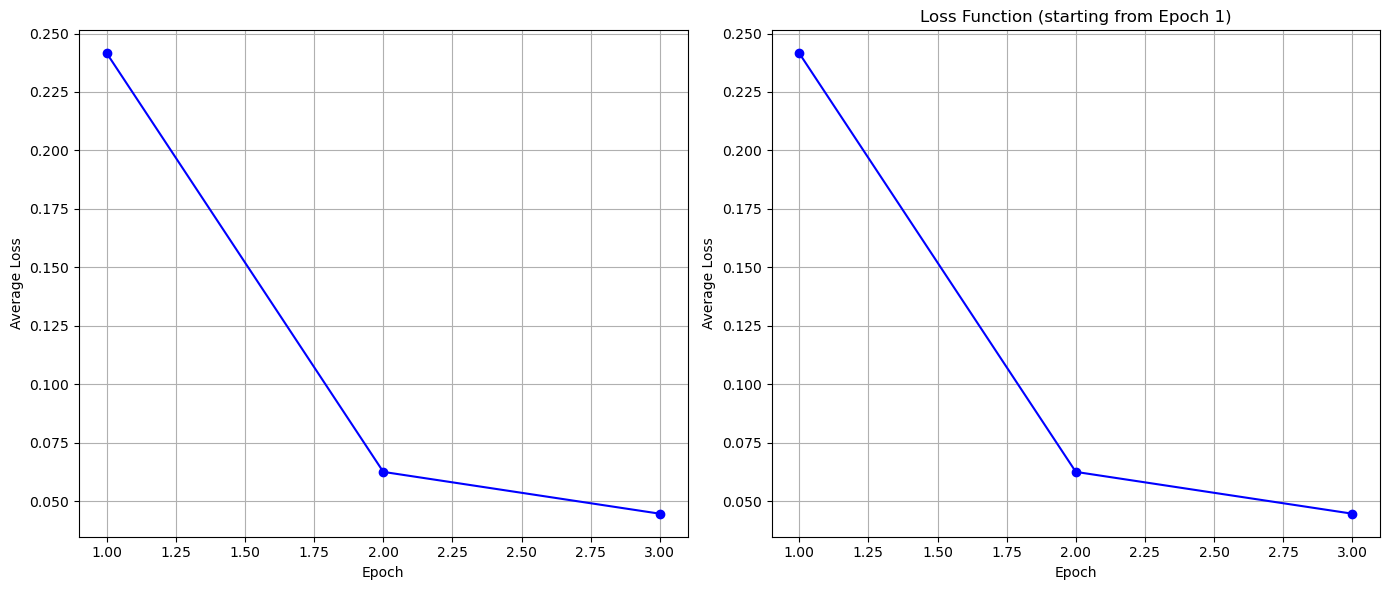

In [29]:
# График обучения
ctdrnn.plot_loss()

#### Предсказание модели

In [30]:
%%time
# Сделаем предсказания
# X_seq - входные данные для предсказания
Y_pred = ctdrnn.predict(X_seq)

CUDA out of memory! Moving model to CPU...
CPU times: user 12.3 s, sys: 15.6 s, total: 27.9 s
Wall time: 3.52 s


In [31]:
len(Y_pred)

172002

In [32]:
len(X_seq)

172002

In [33]:
# Создаем DataFrame из предсказаний
df_predictions = pd.DataFrame(Y_pred, columns=['pred_real', 'pred_imag'])

# Добавляем столбец с индексом (если необходимо)
df_predictions['index'] = np.arange(len(Y_pred))

# Сохраняем в CSV
df_predictions.to_csv('predictions.csv', index=False)

In [34]:
# Оценка модель
# Y_seq - реальные выходные данные
rmse_real, rmse_imag = ctdrnn.evaluate(Y_seq, Y_pred)

print(f'RMSE (Real part): {rmse_real}')
print(f'RMSE (Imaginary part): {rmse_imag}')

RMSE (Real part): 0.14825276050930017
RMSE (Imaginary part): 0.14798069472487357


In [35]:
# Сохранение результатов
results[count_model] = ctdrnn.save_results(Y_seq, Y_pred, rmse_real, rmse_imag)

# display(results)
count_model += 1

#### Сохранение модели после обучения

In [36]:
# Сохраним модель
ctdrnn.save_model('ctdrnn') 

In [37]:
# Построим графики
info_result = pd.DataFrame({
    'default_real': Y_seq[:, 0],  # Реальные значения (вещественная часть)
    'default_imag': Y_seq[:, 1],  # Реальные значения (мнимая часть)
    'pred_real': Y_pred[:, 0],    # Предсказанные значения (вещественная часть)
    'pred_imag': Y_pred[:, 1]     # Предсказанные значения (мнимая часть)
})

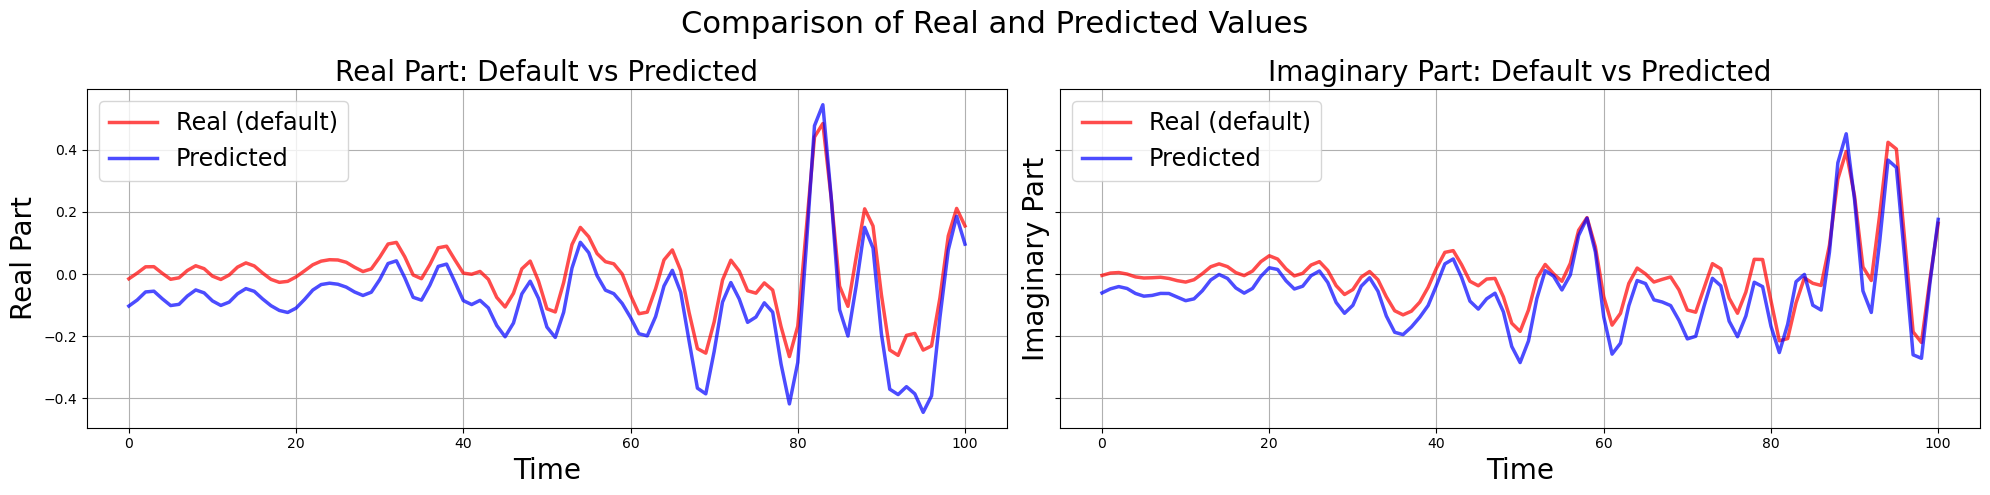

In [38]:
info_result.index = range(len(Y_seq))  # Пример временной шкалы: индексы от 0 до количества наблюдений
ctdrnn.plot_predictions_vs_real(info_result, time_start=0, time_end=1.005e2)

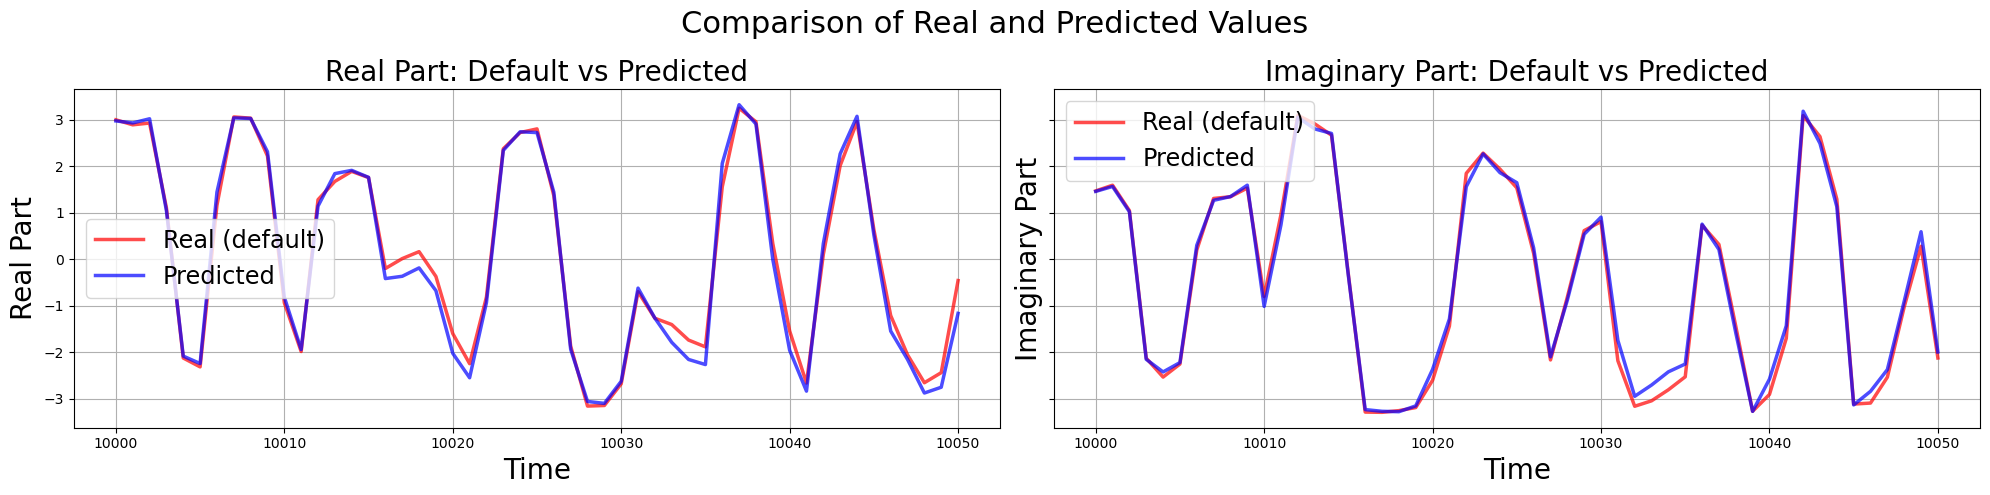

In [39]:
ctdrnn.plot_predictions_vs_real(info_result, time_start=1e4, time_end=1.005e4)

### Complex Time Delay Neural Network (CTDNN)

In [35]:
class CTDNN:
    def __init__(self, input_size, hidden_sizes, output_size, num_layers, num_epochs=100, learning_rate=0.001, p=10, batch_size=64):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.p = p
        self.batch_size = batch_size

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = CTDNN_Model(input_size, hidden_sizes, output_size).to(self.device)
        self.criterion = nn.MSELoss().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        self.scaler_X = StandardScaler()
        self.scaler_Y = StandardScaler()

        self.loss_values = []

    # Функция для создания входных данных с задержкой
    def create_time_delayed_inputs(self, X_real, X_imag, p):
        X_delayed = []
        
        for i in range(p, len(X_real)):
            # Формируем задержки для комплексных данных
            X_real_window = X_real.iloc[i-p:i+1].values  # Вещественная часть
            X_imag_window = X_imag.iloc[i-p:i+1].values  # Мнимая часть
            
            # Комбинируем вещественные и мнимые части
            X_combined = np.concatenate([X_real_window, X_imag_window])
            X_delayed.append(X_combined)
        
        return np.array(X_delayed)

    # Функция для создания выходных данных
    def create_outputs(self, Y_real, Y_imag, p):
        Y_delayed = []
        
        for i in range(p, len(Y_real)):
            # Текущие значения выходных данных (реальная и мнимая части)
            Y_combined = np.array([Y_real.iloc[i], Y_imag.iloc[i]])
            Y_delayed.append(Y_combined)
        
        return np.array(Y_delayed)

    def prepare_data(self, df):
        # Создание временных последовательностей с задержками и обратной связью
        X_seq = self.create_time_delayed_inputs(
            df['input_real'], 
            df['input_imag'], 
            p
        )

        # Создаем выходные данные
        Y_seq = self.create_outputs(
            df['output_real'], 
            df['output_imag'], 
            p
        )

        X_scaled = self.scaler_X.fit_transform(X_seq)
        Y_scaled = self.scaler_Y.fit_transform(Y_seq)

        X_train_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
        Y_train_tensor = torch.tensor(Y_scaled, dtype=torch.float32).to(self.device)

        train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        return X_seq, Y_seq

    def train(self, print_batch=True):
        start_time = time.time()
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            for batch_idx, (X_batch, Y_batch) in enumerate(self.train_loader):
                # Перенос батчей на GPU
                X_batch, Y_batch = X_batch.to(self.device), Y_batch.to(self.device)  
                
                # Прямой проход
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, Y_batch)
                
                # Обратное распространение и оптимизация
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.item() * X_batch.size(0)  # Умножаем на размер батча для подсчета средней потери

                if print_batch:
                    # Вывод прогресса обучения
                    if batch_idx % 10 == 0:
                        print(f'Train Epoch: {epoch} [{batch_idx * len(X_batch)}/{len(self.train_loader.dataset)} ({100. * batch_idx / len(self.train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
                else:       
                    print(f'Train Epoch: {epoch} \tLoss: {loss.item():.6f}')
                    
            # Сохраняем среднее значение функции потерь для текущей эпохи
            avg_loss = epoch_loss / len(self.train_loader.dataset)
            self.loss_values.append(avg_loss)

            # Вывод потери для всей эпохи
            print(f'Train Epoch: {epoch} [DONE]\tLoss: {avg_loss:.6f}')

        end_time = time.time()
        self.elapsed = end_time - start_time

    def predict(self, X_seq):
        self.model.eval()
        with torch.no_grad():
            # Очистка памяти GPU
            torch.cuda.empty_cache()

            try:
                X_scaled = self.scaler_X.transform(X_seq)
                X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
                Y_pred_scaled = self.model(X_tensor).cpu().numpy()
                Y_pred = self.scaler_Y.inverse_transform(Y_pred_scaled)
            except RuntimeError as e:
                # Если возникла ошибка нехватки памяти, переносим модель на CPU
                if "CUDA out of memory" in str(e):
                    print("CUDA out of memory! Moving model to CPU...")
                    self.model.to(torch.device('cpu'))
                    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1).to(torch.device('cpu'))
                    Y_pred_scaled = self.model(X_tensor).cpu().numpy()
                    Y_pred = self.scaler_Y.inverse_transform(Y_pred_scaled)
                else:
                    raise e  # Если это не ошибка нехватки памяти, перенаправляем ее

        return Y_pred

    def evaluate(self, Y_seq, Y_pred):
        rmse_real = np.sqrt(mean_squared_error(Y_seq[:, 0], Y_pred[:, 0]))
        rmse_imag = np.sqrt(mean_squared_error(Y_seq[:, 1], Y_pred[:, 1]))

        return rmse_real, rmse_imag

    def plot_loss(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        epoch_start = 1
        axs[0].plot(range(epoch_start, self.num_epochs + 1), self.loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[1].set_title(f'Loss Function (starting from Epoch {epoch_start})')
        axs[0].grid(True)

        epoch_start = self.num_epochs // 2
        axs[1].plot(range(epoch_start, self.num_epochs + 1), self.loss_values[epoch_start-1:], marker='o', linestyle='-', color='b')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average Loss')
        axs[1].set_title(f'Loss Function (starting from Epoch {epoch_start})')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions_vs_real(self, info_result, time_start, time_end):
        # Фильтрация данных по временной отметке
        filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
        time = filtered_data.index

        # Создание фигуры с двумя подграфиками
        fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
        
        # Общий заголовок для всей фигуры
        fig.suptitle('Comparison of Real and Predicted Values', fontsize=22)

        # Построение графиков реальных и предсказанных значений (вещественная часть)
        axs[0].plot(time, filtered_data['default_real'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
        axs[0].plot(time, filtered_data['pred_real'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
        axs[0].legend(fontsize='xx-large')
        axs[0].grid()
        axs[0].set_xlabel('Time', fontsize=20)
        axs[0].set_ylabel('Real Part', fontsize=20)
        axs[0].set_title('Real Part: Default vs Predicted', fontsize=20)

        # Построение графиков реальных и предсказанных значений (мнимая часть)
        axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='Real (default)')
        axs[1].plot(time, filtered_data['pred_imag'], alpha=0.7, color='blue', lw=2.5, label='Predicted')
        axs[1].legend(fontsize='xx-large')
        axs[1].grid()
        axs[1].set_xlabel('Time', fontsize=20)
        axs[1].set_ylabel('Imaginary Part', fontsize=20)
        axs[1].set_title('Imaginary Part: Default vs Predicted', fontsize=20)

        # Показываем график
        plt.tight_layout()
        plt.show()

    def save_model(self, filename_prefix, save_dir='models'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.pth"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        torch.save(self.model.state_dict(), filepath)

    def load_model(self, filename):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.num_epochs = checkpoint['epoch']

    def save_results(self, Y_seq, Y_pred, rmse_real, rmse_imag):
        results = pd.Series({
            'NAME': 'CTDNN',  # Название модели
            'RMSE VALID REAL': rmse_real,
            'RMSE VALID IMAG': rmse_imag,
            'TIME TRAINING [s]': self.elapsed,
            'PREDICTIONS': Y_pred,
            'PARAMETRS': self.model.state_dict()  # Хранение параметров модели
        })
   
        return results

    def print_params(self):
        html = """
        <table style="border-collapse: collapse; width: 50%;">
        <tr style="background-color: #f2f2f2;">
            <th style="text-align: left; padding: 8px;">Параметр</th>
            <th style="text-align: left; padding: 8px;">Значение</th>
        </tr>
        """
        html += f"<tr><td>Input size</td><td>{self.input_size}</td></tr>"
        html += f"<tr><td>Hidden sizes</td><td>{self.hidden_sizes}</td></tr>"
        html += f"<tr><td>Output size</td><td>{self.output_size}</td></tr>"
        html += f"<tr><td>Number of layers</td><td>{self.num_layers}</td></tr>"
        html += f"<tr><td>Number of epochs</td><td>{self.num_epochs}</td></tr>"
        html += f"<tr><td>Learning rate</td><td>{self.learning_rate}</td></tr>"
        html += f"<tr><td>Input delay (p)</td><td>{self.p}</td></tr>"
        html += f"<tr><td>Batch size</td><td>{self.batch_size}</td></tr>"
        html += "</table>"
        
        display(HTML(html))

In [37]:
class CTDNN_Model(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CTDNN_Model, self).__init__()

        # Создание динамического списка полносвязных слоев
        self.fcs = nn.ModuleList()
        layer_sizes = [input_size] + hidden_sizes
        for i in range(len(layer_sizes) - 1):
            self.fcs.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

        # Финальный выходной слой
        self.fc_out = nn.Linear(hidden_sizes[-1], output_size)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        # Проход через динамически созданные полносвязные слои
        for i, fc in enumerate(self.fcs):
            if i % 2 == 0:
                x = self.relu(fc(x))       # ReLU для четных слоев
            else:
                x = self.leaky_relu(fc(x))  # LeakyReLU для нечетных слоев

        # Финальный выходной слой без активации
        out = self.fc_out(x)
        return out


In [38]:
# Параметры задержки p
p=10 # Входная задержка

# Создадим объект CTDNN
ctdnn = CTDNN(
    input_size=2 * (p + 1), 
    hidden_sizes=[128, 256, 128, 64, 64, 16], 
    output_size=2, 
    num_layers=2,
    num_epochs=100,
    learning_rate=0.001,
    p=p,
    # batch_size=256
    # batch_size=1024
    batch_size=2048
)

In [39]:
# Вывод параметров в виде HTML-таблицы
ctdnn.print_params()

In [40]:
%%time
# Подготовка данных
X_seq, Y_seq = ctdnn.prepare_data(df)

CPU times: user 6.23 s, sys: 563 ms, total: 6.79 s
Wall time: 6.16 s


In [41]:
%%time
# Обучим модель
ctdnn.train()

Train Epoch: 0 [0/172022 (0%)]	Loss: 1.025528
Train Epoch: 0 [20480/172022 (12%)]	Loss: 0.950422
Train Epoch: 0 [40960/172022 (24%)]	Loss: 0.559131
Train Epoch: 0 [61440/172022 (36%)]	Loss: 0.180140
Train Epoch: 0 [81920/172022 (48%)]	Loss: 0.104950
Train Epoch: 0 [102400/172022 (60%)]	Loss: 0.078095
Train Epoch: 0 [122880/172022 (71%)]	Loss: 0.060630
Train Epoch: 0 [143360/172022 (83%)]	Loss: 0.054090
Train Epoch: 0 [163840/172022 (95%)]	Loss: 0.050759
Train Epoch: 0 [DONE]	Loss: 0.309470
Train Epoch: 1 [0/172022 (0%)]	Loss: 0.044151
Train Epoch: 1 [20480/172022 (12%)]	Loss: 0.042496
Train Epoch: 1 [40960/172022 (24%)]	Loss: 0.038618
Train Epoch: 1 [61440/172022 (36%)]	Loss: 0.033425
Train Epoch: 1 [81920/172022 (48%)]	Loss: 0.029781
Train Epoch: 1 [102400/172022 (60%)]	Loss: 0.028751
Train Epoch: 1 [122880/172022 (71%)]	Loss: 0.025007
Train Epoch: 1 [143360/172022 (83%)]	Loss: 0.022518
Train Epoch: 1 [163840/172022 (95%)]	Loss: 0.019987
Train Epoch: 1 [DONE]	Loss: 0.030807
Train Epoc

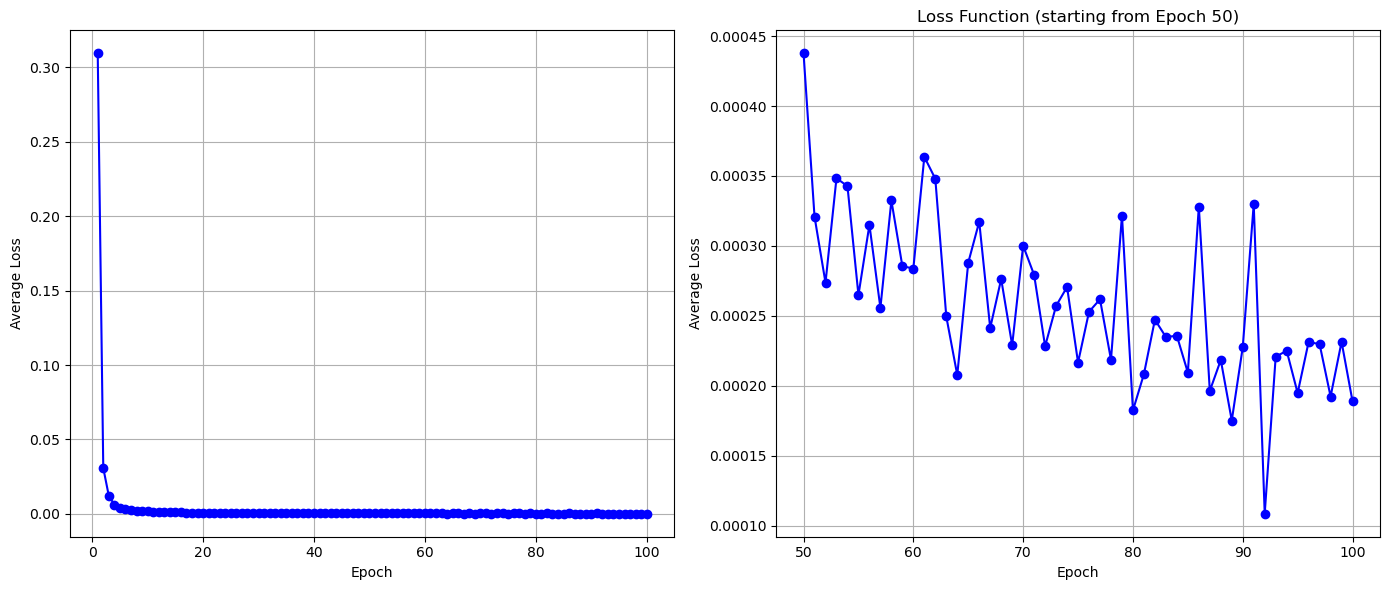

In [42]:
# График обучения
ctdnn.plot_loss()

In [43]:
%%time
# Сделаем предсказания
# X_seq - входные данные для предсказания
Y_pred = ctdnn.predict(X_seq)

CPU times: user 321 ms, sys: 54.2 ms, total: 376 ms
Wall time: 61.1 ms


In [44]:
# Оценка модель
# Y_seq - реальные выходные данные
rmse_real, rmse_imag = ctdnn.evaluate(Y_seq, Y_pred)

print(f'RMSE (Real part): {rmse_real}')
print(f'RMSE (Imaginary part): {rmse_imag}')

RMSE (Real part): 0.02598935179846933
RMSE (Imaginary part): 0.03618600728625962


In [45]:
# Сохранение результатов
results[count_model] = ctdnn.save_results(Y_seq, Y_pred, rmse_real, rmse_imag)

# display(results)
count_model += 1

##### Сохранение модели после обучения

In [46]:
# Сохраним модель
ctdnn.save_model('ctdnn') 

In [47]:
# Построим графики
info_result = pd.DataFrame({
    'default_real': Y_seq[:, 0],  # Реальные значения (вещественная часть)
    'default_imag': Y_seq[:, 1],  # Реальные значения (мнимая часть)
    'pred_real': Y_pred[:, 0],    # Предсказанные значения (вещественная часть)
    'pred_imag': Y_pred[:, 1]     # Предсказанные значения (мнимая часть)
})

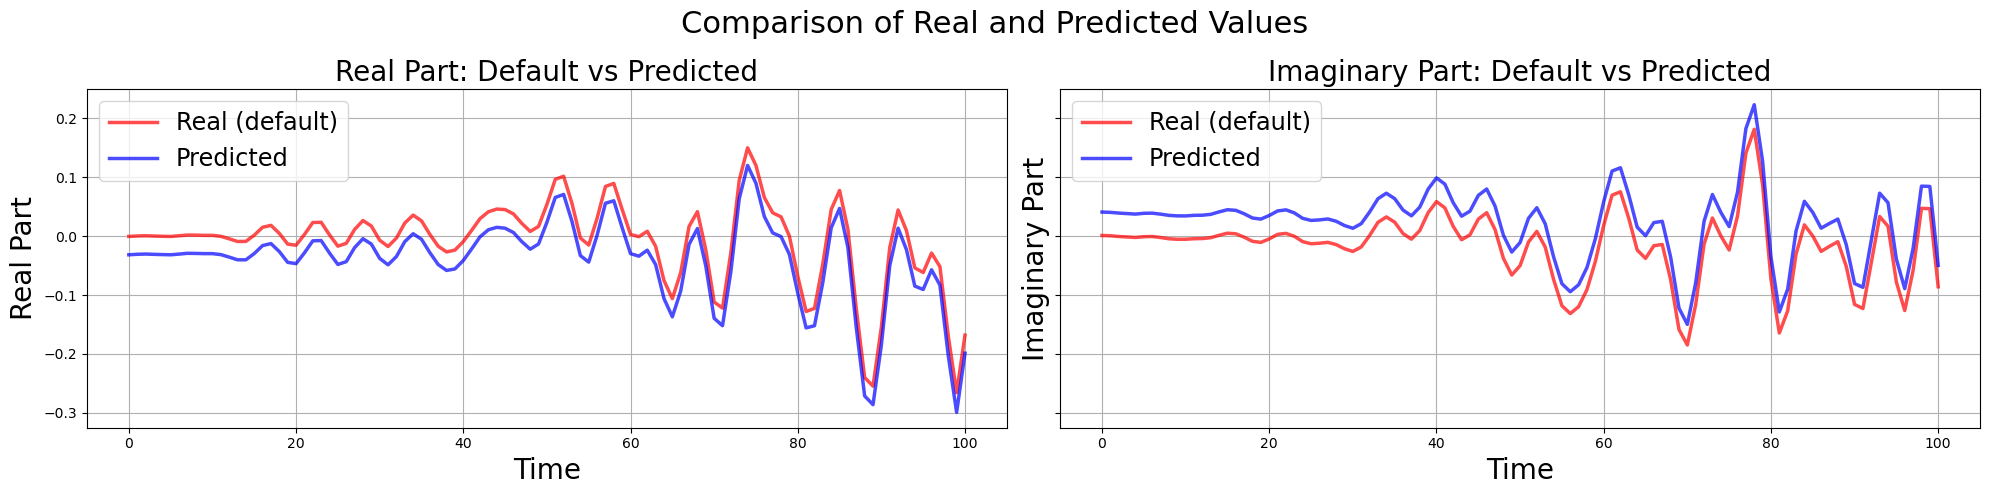

In [48]:
info_result.index = range(len(Y_seq))  # Пример временной шкалы: индексы от 0 до количества наблюдений
ctdnn.plot_predictions_vs_real(info_result, time_start=0, time_end=1.005e2)

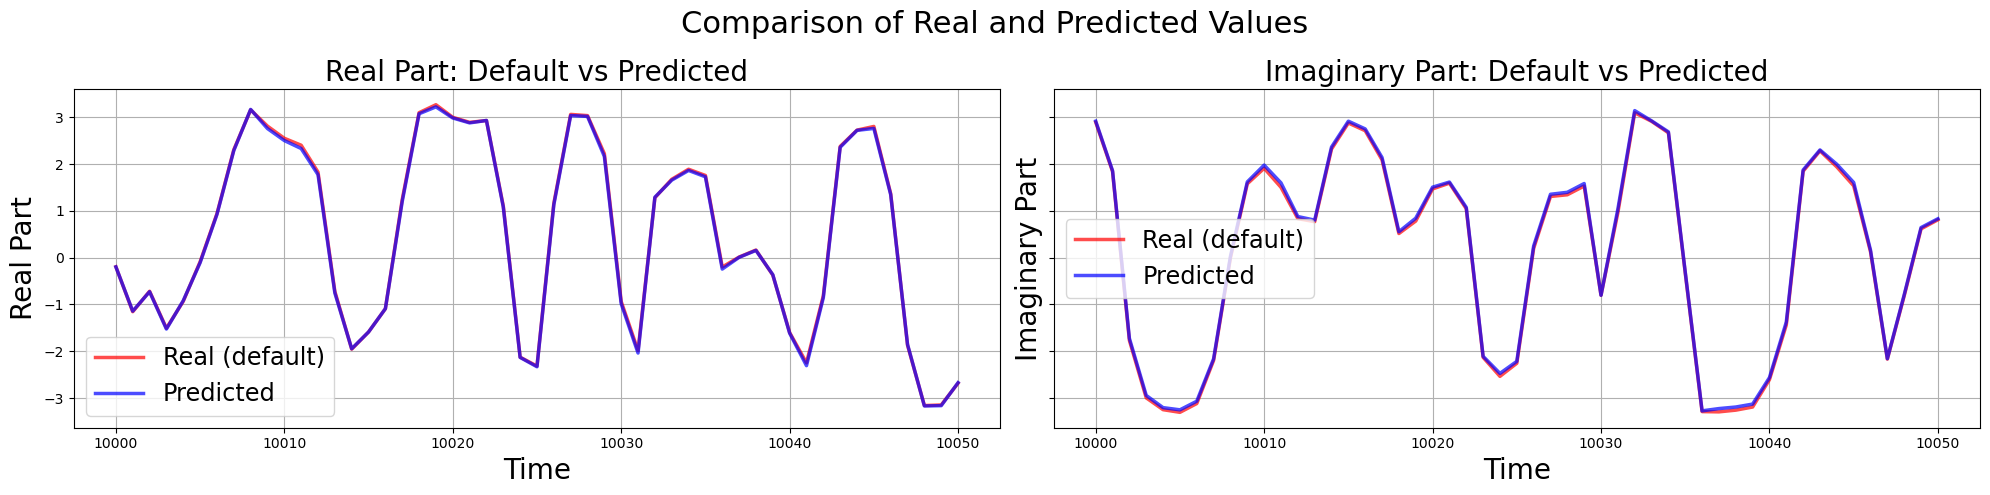

In [49]:
ctdnn.plot_predictions_vs_real(info_result, time_start=1e4, time_end=1.005e4)

### Real Valued Time delay Recurrent Neural Network (RVTDRNN)

### Real Valued Focused Time Delay Neural Network (RVFTDNN)

### Real Valued Recurrent Neural Network (RVRNN)

## Результаты

In [50]:
results = pd.DataFrame(results).T

In [51]:
# Смотрим на результаты
display(results)

NAME RMSE VALID REAL RMSE VALID IMAG TIME TRAINING [s]  \
0  CTDRNN        0.052387        0.051747        578.968915   
1   CTDNN        0.025989        0.036186        151.687136   

                                         PREDICTIONS  \
0  [[-0.025128674, -0.002282036], [-0.024352005, ...   
1  [[-0.031535067, 0.041036174], [-0.030686615, 0...   

                                           PARAMETRS  
0  {'lstm.weight_ih_l0': [[tensor(0.0078), tensor...  
1  {'fcs.0.weight': [[tensor(-0.0956, device='cud...

In [52]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.45 * (1 - (results['RMSE VALID REAL'] / results['RMSE VALID REAL'].max())) +
    0.45 * (1 - (results['RMSE VALID IMAG'] / results['RMSE VALID IMAG'].max())) +
    0.1 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [53]:
# Смотрим на результаты
display(results)

NAME RMSE VALID REAL RMSE VALID IMAG TIME TRAINING [s]  \
1   CTDNN        0.025989        0.036186        151.687136   
0  CTDRNN        0.052387        0.051747        578.968915   

                                         PREDICTIONS  \
1  [[-0.031535067, 0.041036174], [-0.030686615, 0...   
0  [[-0.025128674, -0.002282036], [-0.024352005, ...   

                                           PARAMETRS    RATING  
1  {'fcs.0.weight': [[tensor(-0.0956, device='cud...  0.435877  
0  {'lstm.weight_ih_l0': [[tensor(0.0078), tensor...       0.0

# Машинное обучение

In [20]:
# Здесь будем сохранить результаты обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

In [21]:
# Определение входных и выходных данных
features = df[['input_real', 'input_imag']]
targets = df[['output_real', 'output_imag']]

## Деление на обучающей и валидационной выборки

**Обучение моделей с применением TimeSeriesSplit**

Почему обучаем с применением TimeSeriesSplit, потому что мы обучаем модель, у которой по индексу стоит временный ряд. А чтобы они не пересекались, это поможет инструмент TimeSeriesSplit.

In [22]:
# Не будем создавать по-умолчанию, где n_splits=5, а установим n_splits=10
tscv = TimeSeriesSplit(10)
display(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

In [23]:
# Разделение на обучающую и валидационную выборки
features_train, features_valid, targets_train, targets_valid = train_test_split(features, targets, test_size=0.2, random_state=123456)

## Обучение модели

### LinearRegression

In [24]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), LinearRegression())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={}, scoring='neg_root_mean_squared_error')

In [25]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.8658672581599522
TIME TRAIN [s]: 0.02


**Проверка на валидационной выборки**

In [28]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.7488804442530592
RMSE для мнимой части: 0.7531629903468988
CPU times: user 13.8 ms, sys: 2.61 ms, total: 16.4 ms
Wall time: 4.69 ms


In [29]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                    LinearRegression
RMSE TRAIN                                                      0.865867
RMSE VALID REAL                                                  0.74888
RMSE VALID IMAG                                                 0.753163
TIME TRAINING [s]                                               0.018766
TIME PREDICTION [s]                                                0.004
PREDICTIONS            [[-0.28832698573917814, 1.936889405288186], [-...
PARAMETRS                                                             {}
Name: 0, dtype: object

### KNeighborsRegressor

In [71]:
# Задаем значения гиперпараметров
parameters = {
    # Пример значений, можно добавить свои
    'kneighborsregressor__n_neighbors': [1, 2],  
    # 'weights': ['uniform', 'distance'],
    'kneighborsregressor__weights': ['uniform'],
    # для параметра метрики (1 - манхэттенское расстояние, 2 - евклидово расстояние)
    # 'kneighborsregressor__p': [1]  
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), KNeighborsRegressor())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [1, 2],
                         'kneighborsregressor__weights': ['uniform']},
             scoring='neg_root_mean_squared_error')

In [72]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.3862943803573481
TIME TRAIN [s]: 0.06


**Проверка на валидационной выборки**

In [73]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.14756557815883273
RMSE для мнимой части: 0.1483683860179619
CPU times: user 102 ms, sys: 2.02 ms, total: 104 ms
Wall time: 103 ms


In [74]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                 KNeighborsRegressor
RMSE TRAIN                                                      0.386294
RMSE VALID REAL                                                 0.147566
RMSE VALID IMAG                                                 0.148368
TIME TRAINING [s]                                               0.061688
TIME PREDICTION [s]                                                0.102
PREDICTIONS            [[-0.44020349999999997, 2.974165], [-2.74305, ...
PARAMETRS              {'kneighborsregressor__n_neighbors': 2, 'kneig...
Name: 1, dtype: object

### DecisionTreeRegressor

In [75]:
parameters = {
    'decisiontreeregressor__max_depth': range(1, 101, 10),
    'decisiontreeregressor__min_samples_leaf': [1, 0.5]
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=12345))
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=12345))]),
             param_grid={'decisiontreeregressor__max_depth': range(1, 101, 10),
                         'decisiontreeregressor__min_samples_leaf': [1, 0.5]},
             scoring='neg_root_mean_squared_error')

In [76]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.37621486671960813
TIME TRAIN [s]: 0.3


**Проверка на валидационной выборки**

In [77]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.13459805580403986
RMSE для мнимой части: 0.1339878847137597
CPU times: user 4.8 ms, sys: 2.98 ms, total: 7.77 ms
Wall time: 6.32 ms


In [78]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                               DecisionTreeRegressor
RMSE TRAIN                                                      0.376215
RMSE VALID REAL                                                 0.134598
RMSE VALID IMAG                                                 0.133988
TIME TRAINING [s]                                               0.296888
TIME PREDICTION [s]                                                0.005
PREDICTIONS            [[-0.5637410662983423, 2.8974165193370167], [-...
PARAMETRS              {'decisiontreeregressor__max_depth': 11, 'deci...
Name: 2, dtype: object

### LightGBMRegressor

In [79]:
# Матрица гиперпараметров для LGBMRegressor
parameters = {
    'multioutputregressor__estimator__n_estimators': [10, 25],
    'multioutputregressor__estimator__learning_rate': [0.1, 0.3],
    'multioutputregressor__estimator__max_depth': [5, 15],
    'multioutputregressor__estimator__num_leaves': [5, 10],
}

# Оборачиваем LGBMR в MultiOutputRegressor
multi_target_lgbmr = MultiOutputRegressor(LGBMRegressor())

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_lgbmr)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=LGBMRegressor()))]),
             param_grid={'multioutputregressor__estimator__learning_rate': [0.1,
                                                                            0.3],
                         'multioutputregressor__estimator__max_depth': [5, 15],
                         'multioutputregressor__estimator__n_estimators': [10,
                                                                           25],
                         'multioutputregressor__estimator__num_leaves': [5,
                                                                         10]},
             scoring='neg_root_mean_squared_error')

In [80]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12515, number of used features: 2
[LightGBM] [Info] Start training from score 0.003815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12515, number of used features: 2
[LightGBM] [Info] Start training from score 0.015188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 25026, number of used features: 2
[LightGBM] [Info] Start training 

**Проверка на валидационной выборки**

In [81]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.1713299102926755
RMSE для мнимой части: 0.1723867719656781
CPU times: user 132 ms, sys: 9.17 ms, total: 141 ms
Wall time: 17.6 ms


In [82]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                MultiOutputRegressor
RMSE TRAIN                                                      0.416362
RMSE VALID REAL                                                  0.17133
RMSE VALID IMAG                                                 0.172387
TIME TRAINING [s]                                               0.126176
TIME PREDICTION [s]                                                0.016
PREDICTIONS            [[-0.33606733176649484, 3.0045329003957586], [...
PARAMETRS              {'multioutputregressor__estimator__learning_ra...
Name: 3, dtype: object

### CatBoostRegressor

In [83]:
# Матрица гиперпараметров для CatBoostRegressor
parameters = {
    'multioutputregressor__estimator__iterations': [5, 10],
    'multioutputregressor__estimator__learning_rate': [0.1, 0.5],
    'multioutputregressor__estimator__depth': [5, 15],
}

# Оборачиваем CatBoostRegressor в MultiOutputRegressor
multi_target_cbr = MultiOutputRegressor(CatBoostRegressor())

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_cbr)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x78989bd3fc10>))]),
             param_grid={'multioutputregressor__estimator__depth': [5, 15],
                         'multioutputregressor__estimator__iterations': [5, 10],
                         'multioutputregressor__estimator__learning_rate': [0.1,
                                                                            0.5]},
             scoring='neg_root_mean_squared_error')

In [84]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

0:	learn: 1.9013737	total: 48.4ms	remaining: 193ms
1:	learn: 1.7306095	total: 50.2ms	remaining: 75.3ms
2:	learn: 1.5795488	total: 52.6ms	remaining: 35.1ms
3:	learn: 1.4394106	total: 54.5ms	remaining: 13.6ms
4:	learn: 1.3128407	total: 56.2ms	remaining: 0us
0:	learn: 1.9010003	total: 5.93ms	remaining: 23.7ms
1:	learn: 1.7313272	total: 8.95ms	remaining: 13.4ms
2:	learn: 1.5814113	total: 11.8ms	remaining: 7.85ms
3:	learn: 1.4447014	total: 15.1ms	remaining: 3.78ms
4:	learn: 1.3188330	total: 18.6ms	remaining: 0us
0:	learn: 1.9039942	total: 2.17ms	remaining: 8.69ms
1:	learn: 1.7343293	total: 4ms	remaining: 6ms
2:	learn: 1.5823872	total: 5.87ms	remaining: 3.91ms
3:	learn: 1.4419239	total: 7.95ms	remaining: 1.99ms
4:	learn: 1.3152449	total: 10ms	remaining: 0us
0:	learn: 1.9005997	total: 1.68ms	remaining: 6.72ms
1:	learn: 1.7316318	total: 3.11ms	remaining: 4.67ms
2:	learn: 1.5763051	total: 4.64ms	remaining: 3.09ms
3:	learn: 1.4377097	total: 6.38ms	remaining: 1.59ms
4:	learn: 1.3136369	total: 8.5

**Проверка на валидационной выборки**

In [85]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.14433298570142392
RMSE для мнимой части: 0.1442852424131891
CPU times: user 18.5 ms, sys: 5.55 ms, total: 24 ms
Wall time: 6.42 ms


In [86]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                MultiOutputRegressor
RMSE TRAIN                                                       0.38449
RMSE VALID REAL                                                 0.144333
RMSE VALID IMAG                                                 0.144285
TIME TRAINING [s]                                               5.530213
TIME PREDICTION [s]                                                0.006
PREDICTIONS            [[-0.5793409857007769, 3.00895793161571], [-2....
PARAMETRS              {'multioutputregressor__estimator__depth': 15,...
Name: 4, dtype: object

### BaggingRegressor

In [87]:
# Матрица гиперпараметров для BaggingRegressor
parameters = {
    'baggingregressor__n_estimators': [10, 25],
    'baggingregressor__random_state': [12345] 
}

# Инициализируем модель с параметрами и создаем конвейер
# Инициализируем BaggingRegressor отдельно
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), random_state=12345)
pipeline_scale = make_pipeline(StandardScaler(), bagging_model)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('baggingregressor',
                                        BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                                                         random_state=12345))]),
             param_grid={'baggingregressor__n_estimators': [10, 25],
                         'baggingregressor__random_state': [12345]},
             scoring='neg_root_mean_squared_error')

In [88]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.35696216171103107
TIME TRAIN [s]: 4.5


**Проверка на валидационной выборки**

In [89]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.12555557093909708
RMSE для мнимой части: 0.1261163382483048
CPU times: user 74.8 ms, sys: 953 µs, total: 75.8 ms
Wall time: 74.7 ms


In [90]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                    BaggingRegressor
RMSE TRAIN                                                      0.356962
RMSE VALID REAL                                                 0.125556
RMSE VALID IMAG                                                 0.126116
TIME TRAINING [s]                                               4.503093
TIME PREDICTION [s]                                                0.073
PREDICTIONS            [[-0.5211061075152857, 3.000718101419898], [-2...
PARAMETRS              {'baggingregressor__n_estimators': 25, 'baggin...
Name: 5, dtype: object

## Результаты

In [35]:
results = pd.DataFrame(results).T

In [36]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   NAME                 1 non-null      object
 1   RMSE TRAIN           1 non-null      object
 2   RMSE VALID REAL      1 non-null      object
 3   RMSE VALID IMAG      1 non-null      object
 4   TIME TRAINING [s]    1 non-null      object
 5   TIME PREDICTION [s]  1 non-null      object
 6   PREDICTIONS          1 non-null      object
 7   PARAMETRS            1 non-null      object
dtypes: object(8)
memory usage: 180.0+ bytes


In [42]:
predictions = results.PREDICTIONS.iloc[0]  # Получаем список предсказаний
length = len(predictions)  # Вычисляем длину списка
print(f"Длина предсказания: {length}") 

Длина предсказания: 34407


In [39]:
results.PREDICTIONS

0    [[-0.28832698573917814, 1.936889405288186], [-...
Name: PREDICTIONS, dtype: object

In [31]:
# Смотрим на результаты
display(results)

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG  \
0  LinearRegression   0.865867         0.74888        0.753163   

  TIME TRAINING [s] TIME PREDICTION [s]  \
0          0.018766               0.004   

                                         PREDICTIONS PARAMETRS  
0  [[-0.28832698573917814, 1.936889405288186], [-...        {}

In [93]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.45 * (1 - (results['RMSE VALID REAL'] / results['RMSE VALID REAL'].max())) +
    0.45 * (1 - (results['RMSE VALID IMAG'] / results['RMSE VALID IMAG'].max())) +
    0.1 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max()))
    # 0.1 * (1 - (results['TIME PREDICTION [s]'] / results['TIME PREDICTION [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [94]:
# Смотрим на результаты
display(results)

NAME RMSE TRAIN RMSE VALID REAL RMSE VALID IMAG  \
2  DecisionTreeRegressor   0.376215        0.134598        0.133988   
1    KNeighborsRegressor   0.386294        0.147566        0.148368   
3   MultiOutputRegressor   0.416362         0.17133        0.172387   
5       BaggingRegressor   0.356962        0.125556        0.126116   
4   MultiOutputRegressor    0.38449        0.144333        0.144285   
0       LinearRegression   0.865867         0.74888        0.753163   

  TIME TRAINING [s] TIME PREDICTION [s]  \
2          0.296888               0.005   
1          0.061688               0.102   
3          0.126176               0.016   
5          4.503093               0.073   
4          5.530213               0.006   
0          0.020961               0.003   

                                         PREDICTIONS  \
2  [[-0.5637410662983423, 2.8974165193370167], [-...   
1  [[-0.44020349999999997, 2.974165], [-2.74305, ...   
3  [[-0.33606733176649484, 3.0045329003957586], [...   
5  [[-0.5211061075152857, 3.000718101419898], [-2...   
4  [[-0.5793409857007769, 3.00895793161571], [-2....   
0  [[-0.28832698573917814, 1.936889405288186], [-...   

                                           PARAMETRS    RATING  
2  {'decisiontreeregressor__max_depth': 11, 'deci...  0.833697  
1  {'kneighborsregressor__n_neighbors': 2, 'kneig...  0.821566  
3  {'multioutputregressor__estimator__learning_ra...  0.791769  
5  {'baggingregressor__n_estimators': 25, 'baggin...  0.767775  
4  {'multioutputregressor__estimator__depth': 15,...  0.727063  
0                                                 {}  0.099621

**Создадим отдельный датасет, в котором будет храниться реальное значение и предсказания модели**

In [95]:
# Используем индексы валидационных данных
info_result = pd.DataFrame(index=targets_valid.index)

info_result['default_real'] = targets_valid['output_real']
info_result['default_imag'] = targets_valid['output_imag']

for i, name_model in enumerate(results['NAME']):
    info_result[name_model+'_real'] = results['PREDICTIONS'][i][:, 0]  # Предсказанные значения действительной части
    info_result[name_model+'_imag'] = results['PREDICTIONS'][i][:, 1]  # Предсказанные значения действительной части

# Сортировка DataFrame по индексу
info_result = info_result.sort_index()

info_result.head()

default_real  default_imag  DecisionTreeRegressor_real  \
time                                                                   
6.500000e-08      0.000358     -0.001267                   -0.003513   
8.000000e-08      0.000814     -0.000496                   -0.003214   
9.000000e-08      0.001889     -0.004296                   -0.003431   
1.800000e-07     -0.012080     -0.011916                   -0.009650   
1.900000e-07      0.026646     -0.014216                    0.004099   

              DecisionTreeRegressor_imag  KNeighborsRegressor_real  \
time                                                                 
6.500000e-08                   -0.000698                  0.000346   
8.000000e-08                   -0.000472                  0.000398   
9.000000e-08                   -0.002047                  0.001465   
1.800000e-07                   -0.002516                 -0.015121   
1.900000e-07                   -0.009515                  0.063197   

              KNeighborsRegressor_imag  MultiOutputRegressor_real  \
time                                                                
6.500000e-08                 -0.001271                  -0.118049   
8.000000e-08                 -0.000223                  -0.118049   
9.000000e-08                 -0.005154                  -0.118049   
1.800000e-07                 -0.011610                  -0.118049   
1.900000e-07                 -0.011673                  -0.118049   

              MultiOutputRegressor_imag  BaggingRegressor_real  \
time                                                             
6.500000e-08                   0.028836               0.552150   
8.000000e-08                   0.028836               0.552150   
9.000000e-08                   0.028836               0.552150   
1.800000e-07                   0.028836              -0.343024   
1.900000e-07                   0.028836               0.552150   

              BaggingRegressor_imag  LinearRegression_real  \
time                                                         
6.500000e-08               0.427222              -0.017098   
8.000000e-08               0.427222              -0.017098   
9.000000e-08              -0.268951              -0.033412   
1.800000e-07               0.427222              -0.043926   
1.900000e-07              -0.268951              -0.012356   

              LinearRegression_imag  
time                                 
6.500000e-08              -0.007220  
8.000000e-08              -0.007220  
9.000000e-08              -0.024787  
1.800000e-07              -0.027412  
1.900000e-07              -0.010523

In [96]:
def plot_predictions_vs_real(info_result, time_start, time_end):
    # Определяем количество моделей, минус 1 для 'default_real' и 'default_imag'
    num_models = len(info_result.columns) // 2 - 1  

    for i in range(num_models):
        col_real = 'default_real'
        col_pred_real = info_result.columns[2 * i + 2]
        col_pred_imag = info_result.columns[2 * i + 3]

        # Фильтрация данных по временной отметке
        filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
        time = filtered_data.index

        # Создание фигуры с двумя подграфиками
        fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
        
        # Общий заголовок для всей фигуры
        fig.suptitle(f'Graph of default and predicted values ({col_pred_real.split("_")[0]})', fontsize=22)

        # Построение графиков реальных значений
        axs[0].plot(time, filtered_data[col_real], alpha=0.7, color='red', lw=2.5, label='default')
        axs[0].plot(time, filtered_data[col_pred_real], alpha=0.7, color='blue', lw=2.5, label='prediction')
        axs[0].legend(fontsize='xx-large')
        axs[0].grid()
        axs[0].set_xlabel('Time series', fontsize=20)
        axs[0].set_ylabel('Value', fontsize=20)
        axs[0].set_title('REAL', fontsize=20)

        # Построение графиков мнимых значений
        axs[1].plot(time, filtered_data['default_imag'], alpha=0.7, color='red', lw=2.5, label='default')
        axs[1].plot(time, filtered_data[col_pred_imag], alpha=0.7, color='blue', lw=2.5, label='prediction')
        axs[1].legend(fontsize='xx-large')
        axs[1].grid()
        axs[1].set_xlabel('Time series', fontsize=20)
        axs[1].set_ylabel('Value', fontsize=20)
        axs[1].set_title('IMAG', fontsize=20)

        # Показываем график
        plt.tight_layout()
        plt.show()

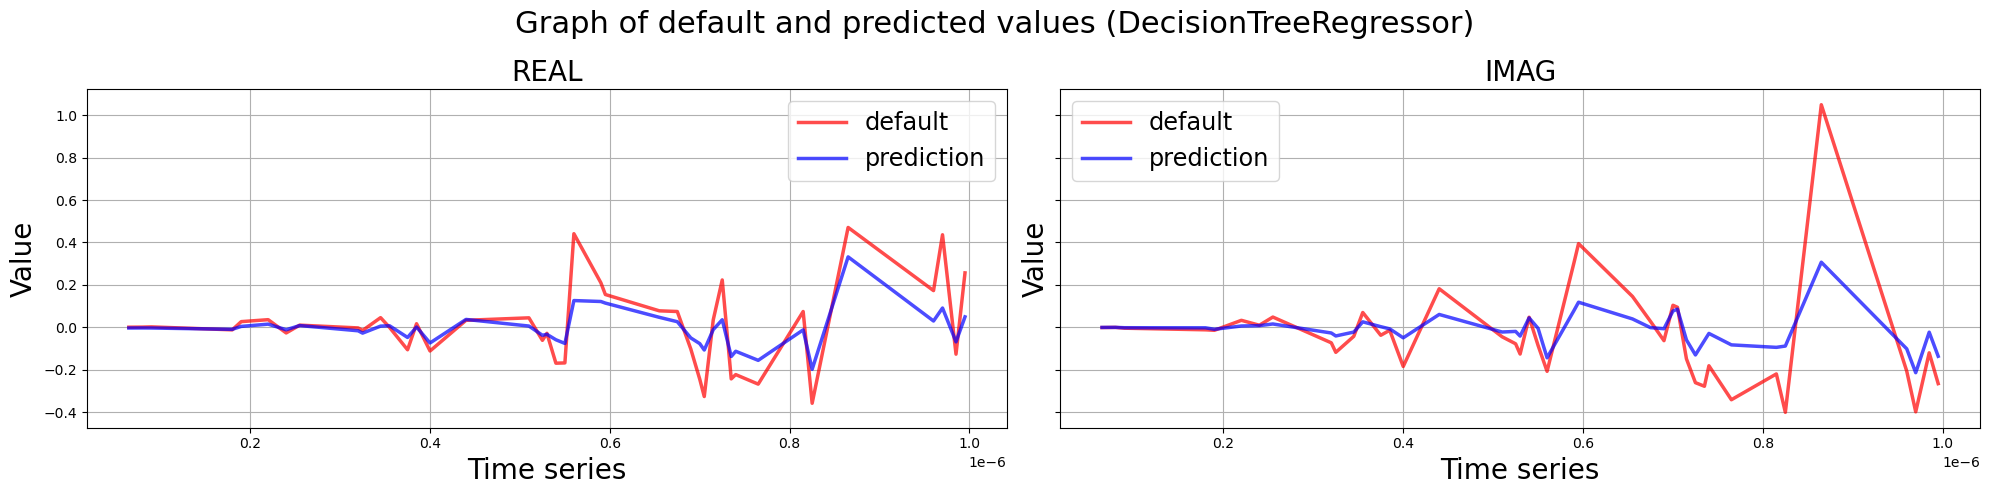

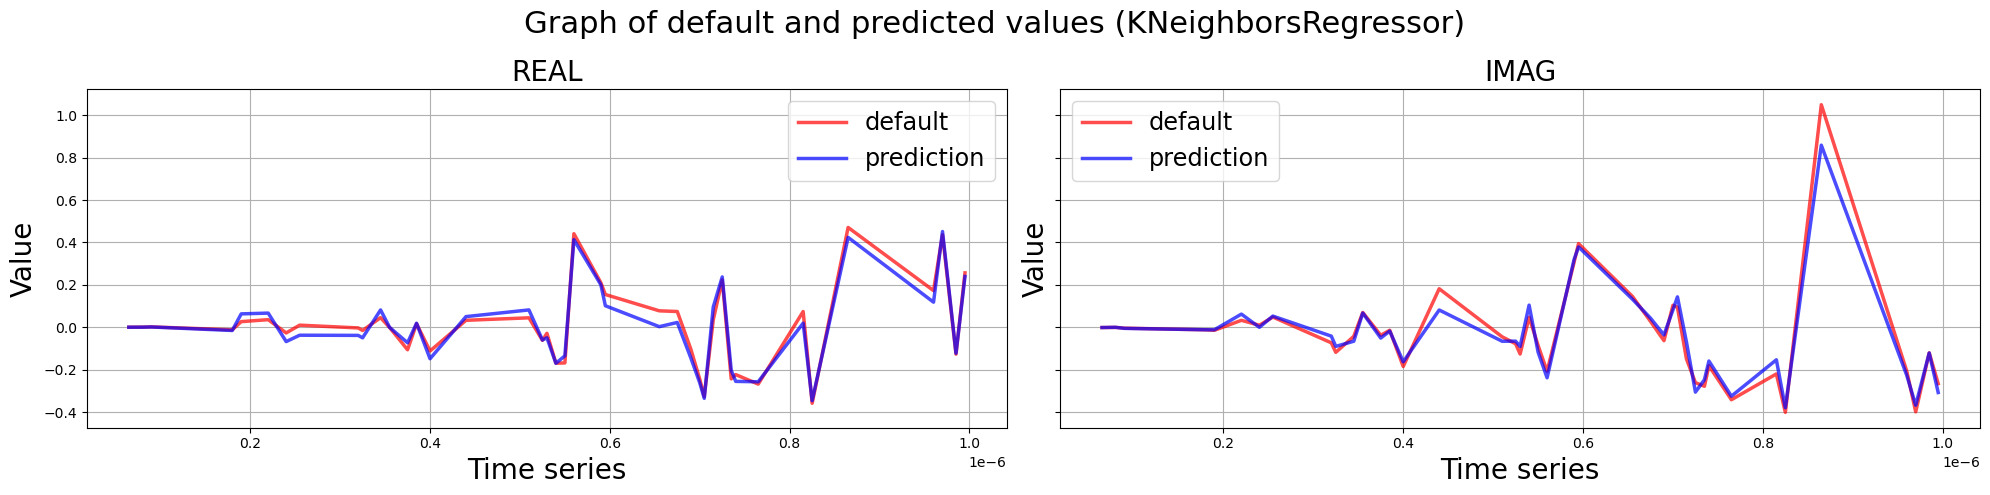

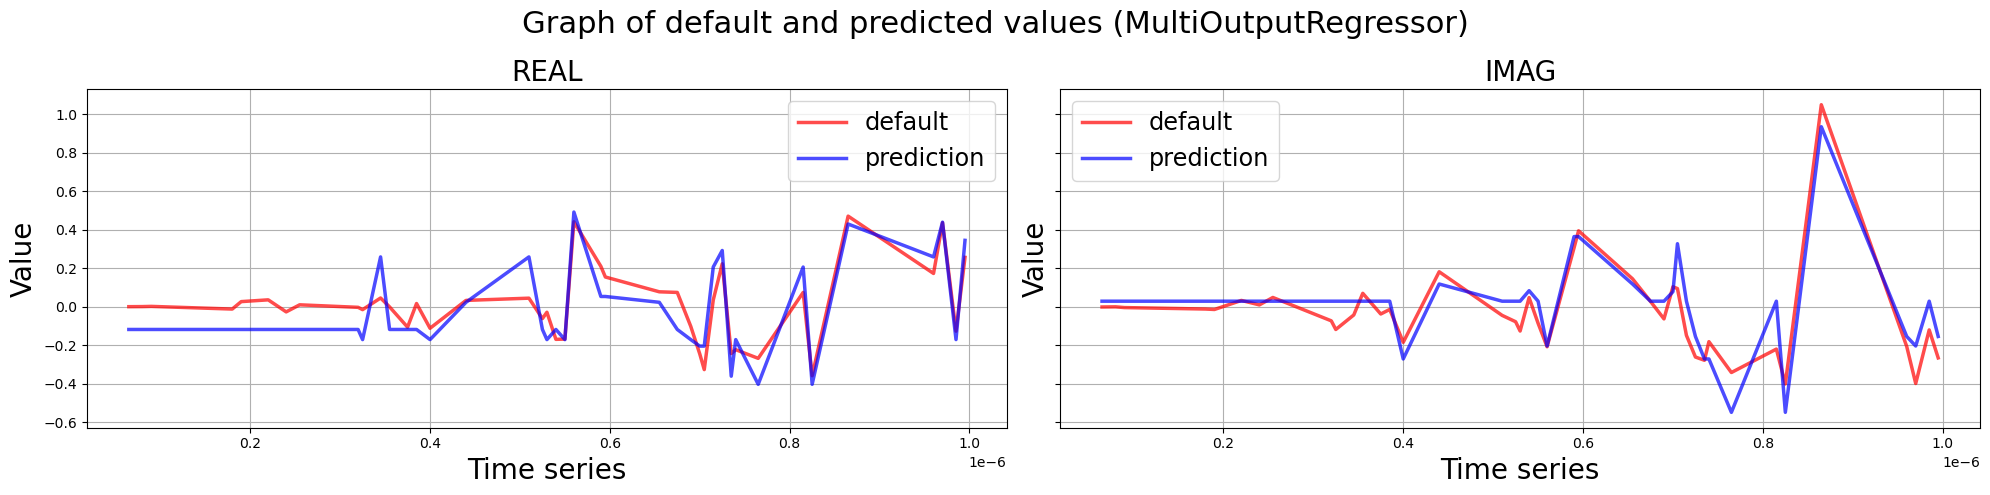

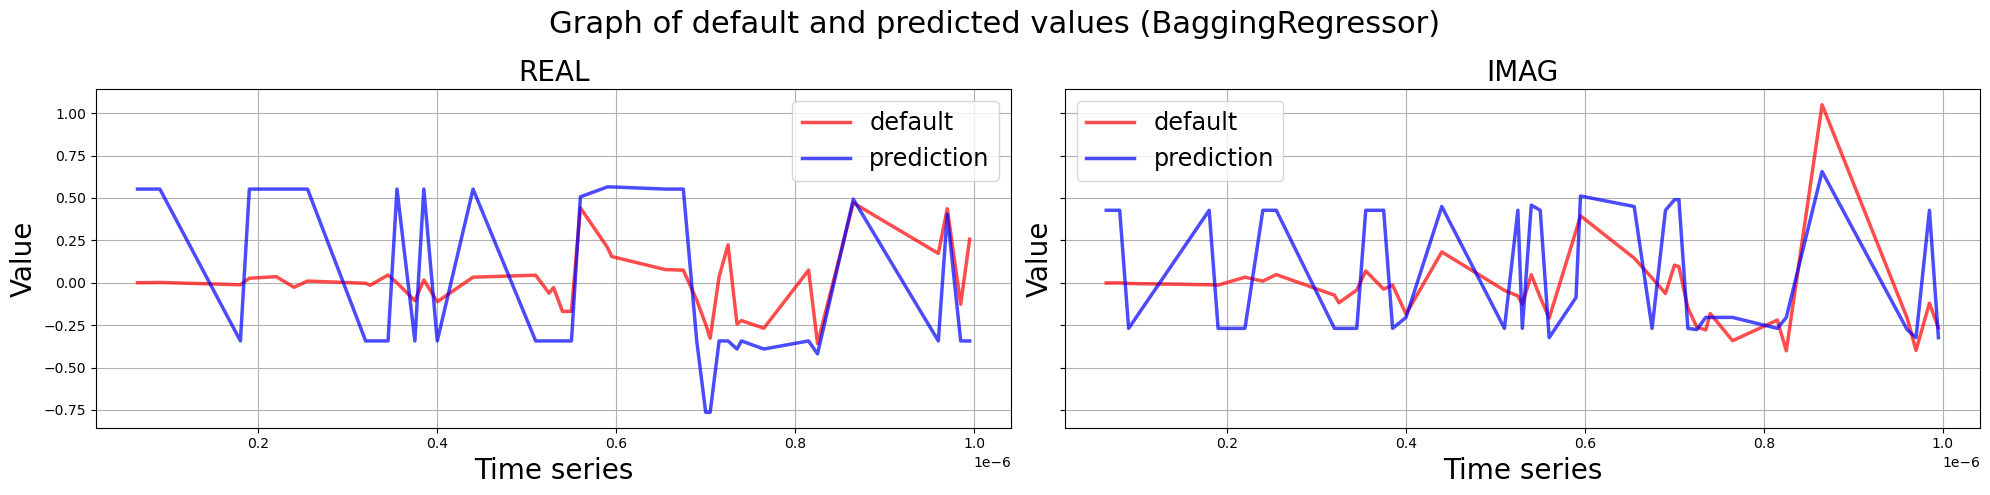

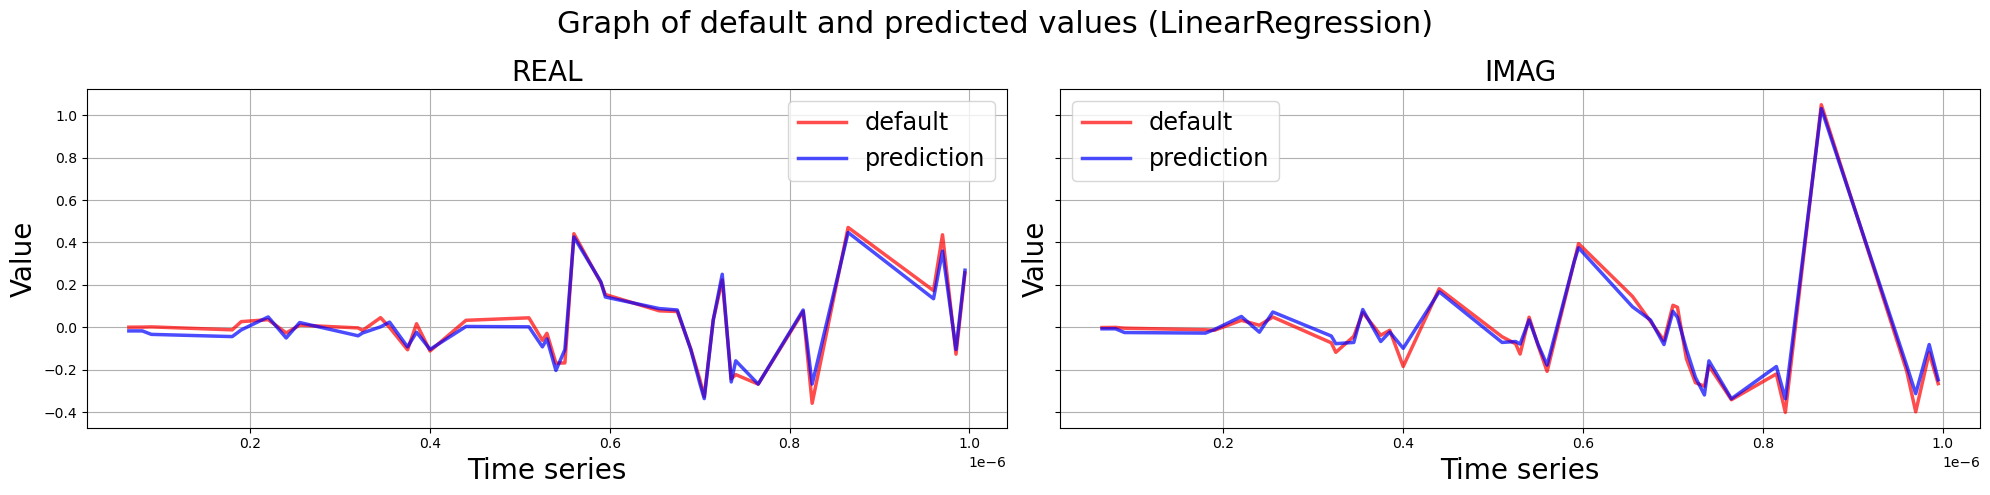

In [97]:
plot_predictions_vs_real(info_result, time_start=0, time_end=1e-6)

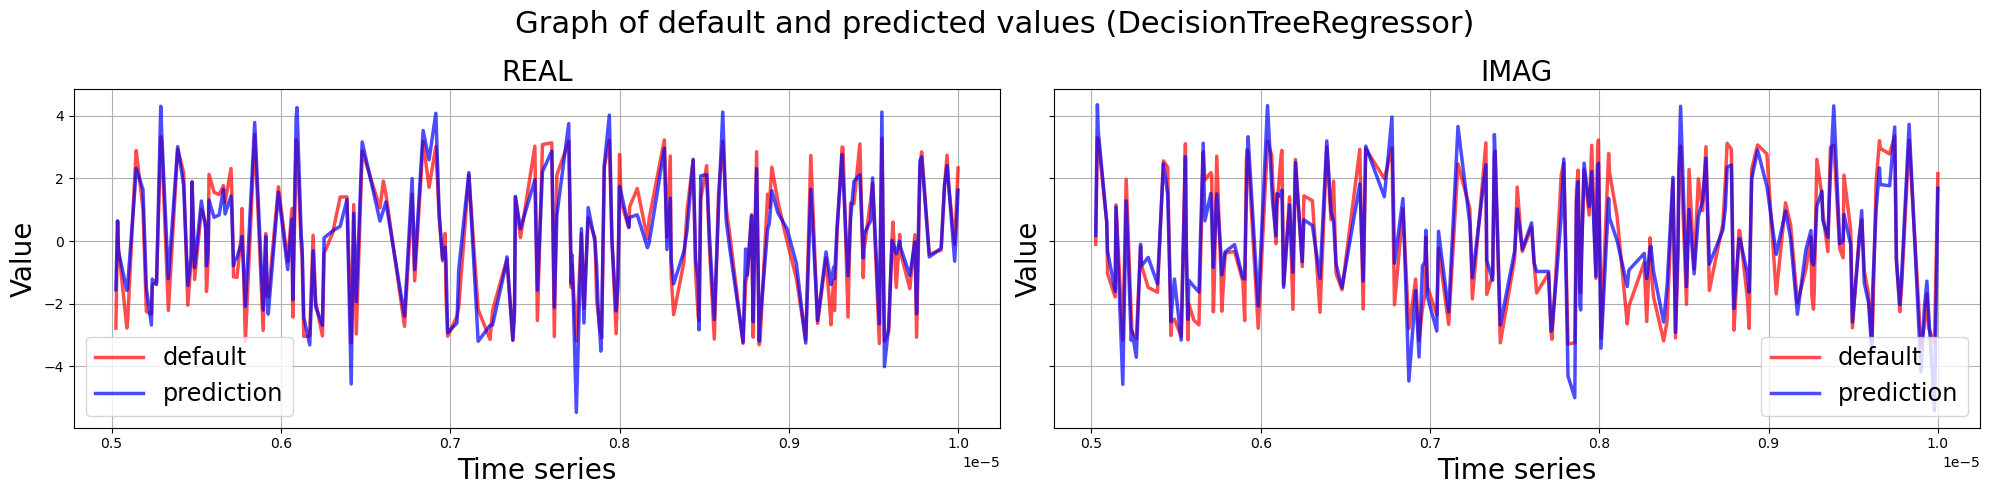

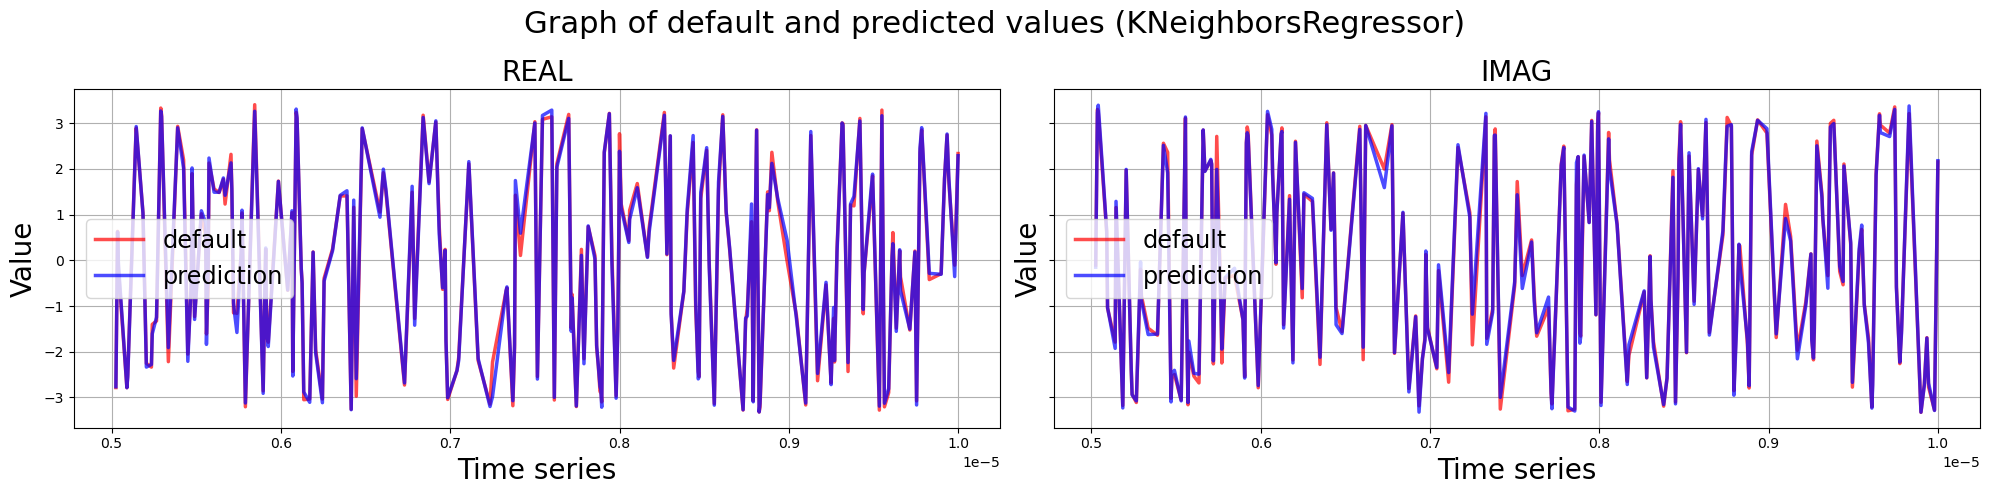

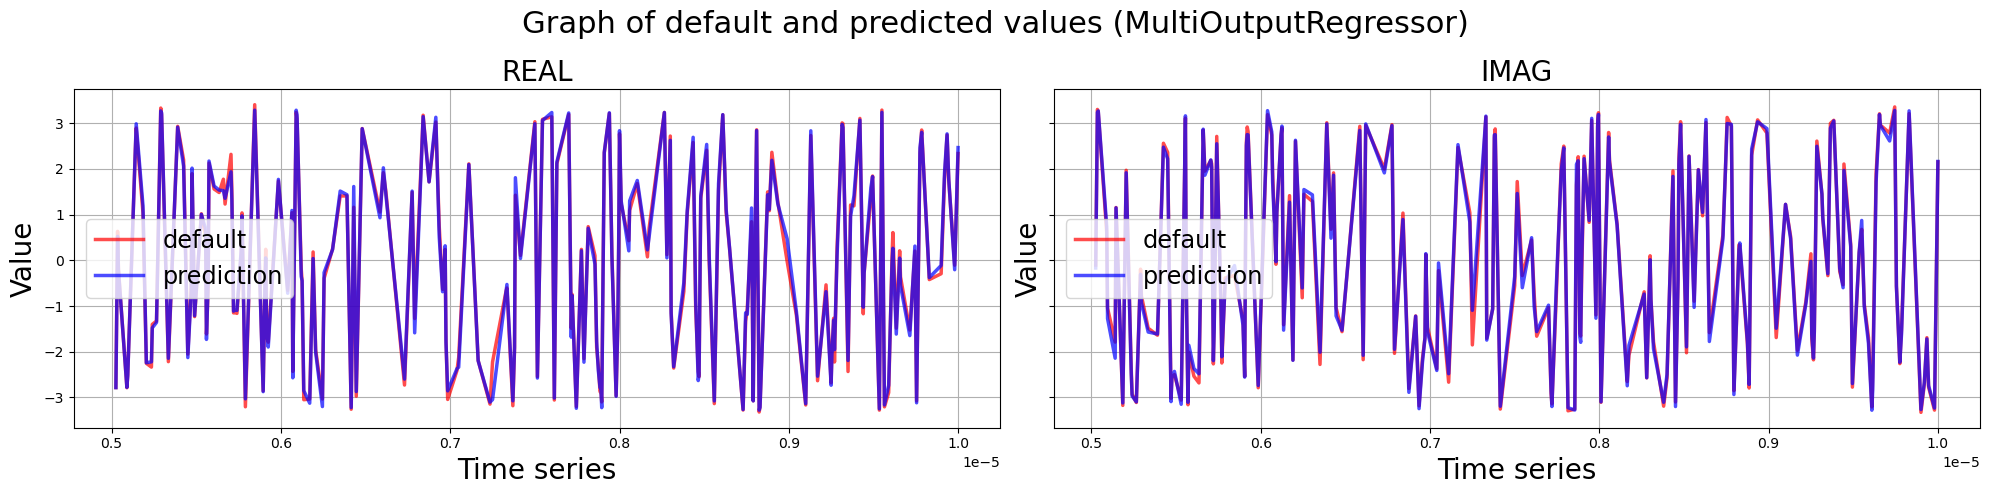

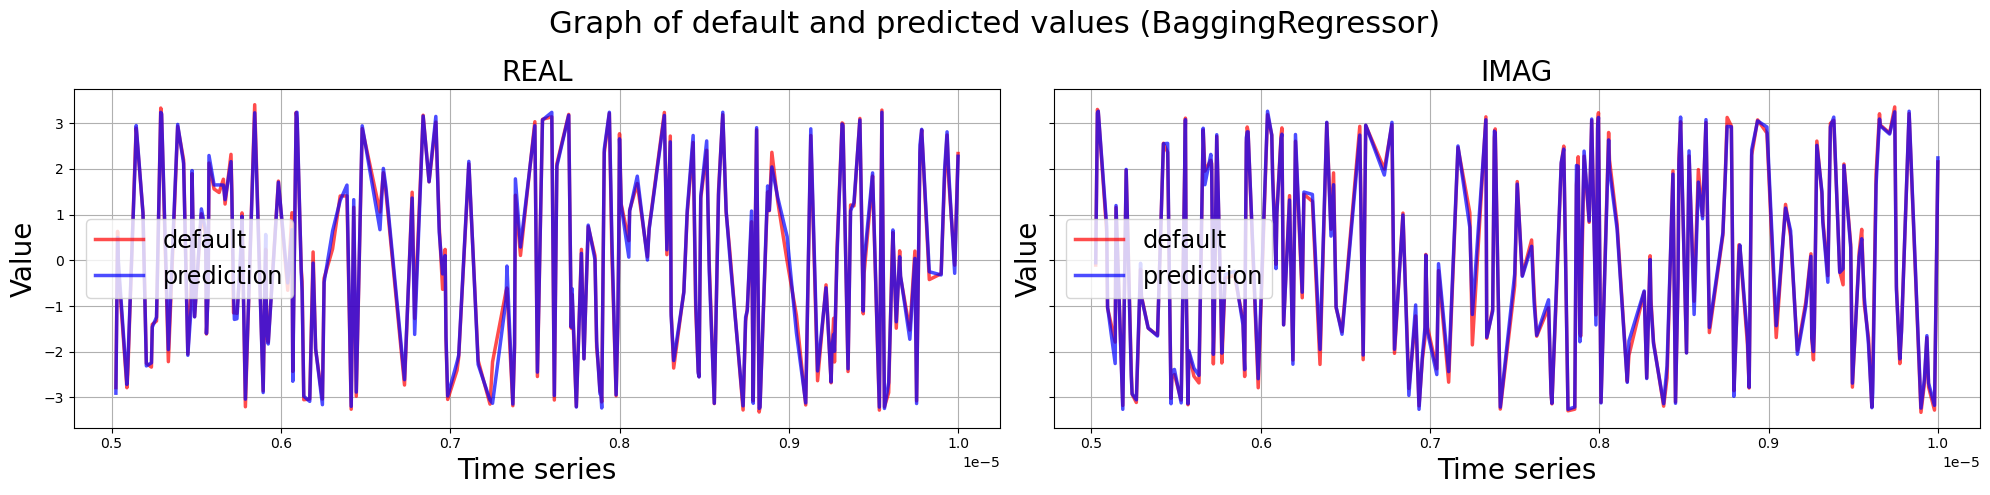

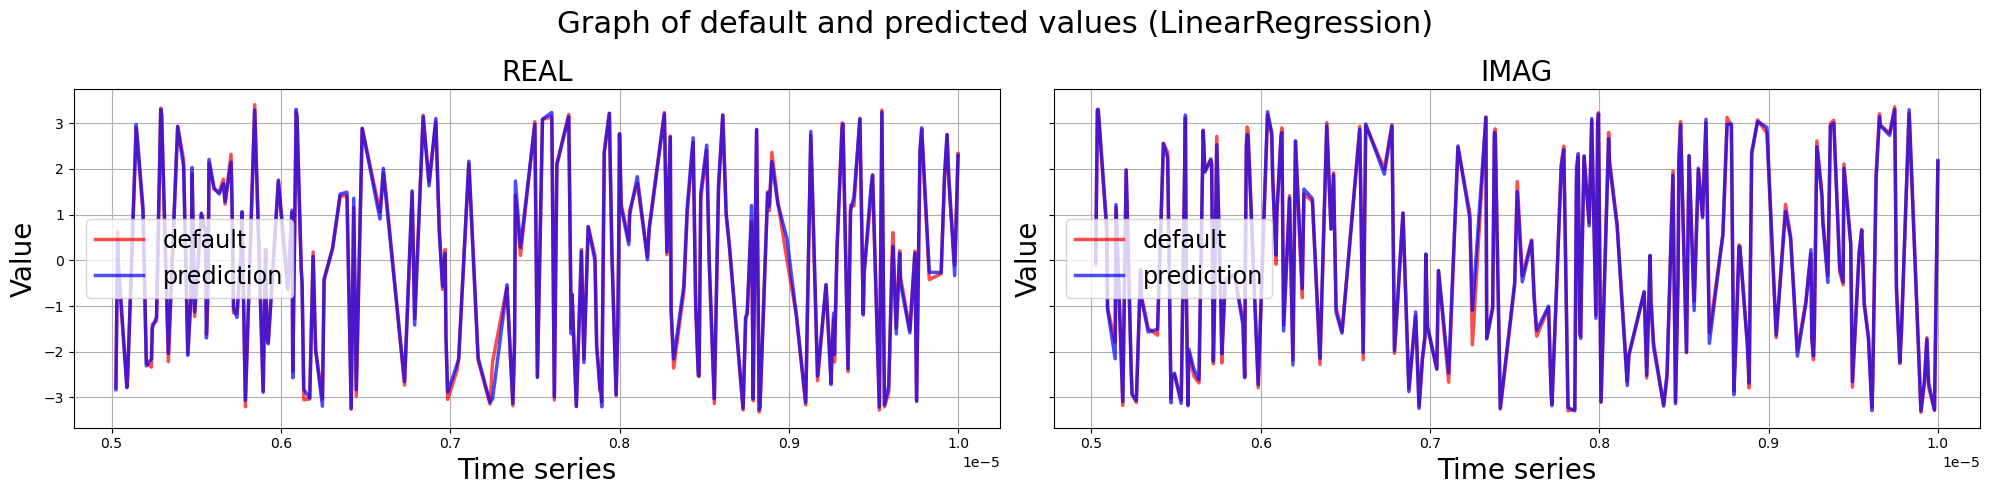

In [98]:
plot_predictions_vs_real(info_result, time_start=0.5e-5, time_end=1e-5)